In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import torch
from entmax import entmax_bisect, entmax15, sparsemax
from torch.nn.functional import softmax
from tqdm import tqdm

np.random.seed(seed=3154) # Set seed for reproducibility
mpl.rcParams['text.usetex'] = True # Enable LaTeX rendering

# Tsallis Value Iteration

In [2]:
def log_alpha(Pi, alpha):
    return (pow(Pi, alpha - 1) - 1)/(alpha - 1)
    
def tsallis_entropy(Pi, alpha):
    return - Pi * log_alpha(Pi, alpha)
    
# Tsallis Regularized Value Iteration
def Tsallis(S, A, T0, P, R, V0, gamma, lamb=1, alpha=1):
    V  = V0
    # Save state value functions
    vs = list()
    for i in tqdm(range(1, T0)):
        # Compute Q
        Q  = R + gamma * np.matmul(P, V)
        Q  = Q.reshape(S, A)

        if lamb:
            if alpha==1:
                Pi = softmax(torch.tensor(Q/lamb), dim=1)
            elif alpha==1.5:
                Pi = entmax15(torch.tensor(Q/(alpha*lamb)))
            elif alpha==2:
                Pi = sparsemax(torch.tensor(Q/(alpha*lamb)))
            else:
                Pi = entmax_bisect(torch.tensor(Q/(alpha*lamb)), alpha=alpha)
            Pi = np.array(Pi)
        else:
            # Compute policy using Dirac distribution (deterministic policy)
            Pi = np.zeros((S, A))
            idx = np.argmax(Q, axis=1)
            Pi[np.arange(S), idx] = 1

        # Compute V
        delta = 1e-4 * int(alpha==1)
        V  = np.sum(Pi * Q + lamb * tsallis_entropy(Pi, alpha + delta), axis=1)
        vs.append(V)
        V  = V[:, np.newaxis]
    return vs, Pi

# Random MDP

In [3]:
def setup_random_mdp(S, A, seed=3154):
    '''
    Setup random MDP.
        S  - State space cardinality
        A  - Action space cardinality
        R  - Reward function
    '''
    # set random seed for reproducibility
    np.random.seed(seed=seed)
    sparse = np.random.binomial(1, 0.05, size=(S*A, S))
    # Check that there are no terminal states
    for i in range(A*S):
        if sum(sparse[i, :]) == 0:
            sparse[i, np.random.randint(S)] = 1

    # Generate Transition Matrix 
    P = sparse * np.random.uniform(0, 1, size=(S*A, S)) # P(s'|s, a) = P[s * |A| + (a - 1), s']
    # Normalize
    P /= np.sum(P, 1)[:, np.newaxis]

    # Generate uniformm rewards
    R = np.random.uniform(low=0, high=1, size=(S*A, 1)) # R(s, a) = R[S*A-1]

    return P, R

Random MDP environment variables

In [4]:
A     = 5    # Action Space cardinality
S     = 10   # State Space cardinality
T0    = 50   # Value Iteration iterations
gamma = 0.90 # Discount Factor

# Ploting Function

In [13]:
def plot_lambda_data(title, data_list, key, fontsize_multiplier=1):
    if key=='lambdas':
        lambda_symbol = r'$\lambda$'
    else:
        lambda_symbol = r'$\alpha$'

    # Create a plot
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each dataset with a different color and label if i is an integer
    for i, data in enumerate(data_list):
        if isinstance(data, int):
            ax.plot(data_list[key], data_list[data], label=f'Action {i}', linewidth=3)

    # Add title and labels
    ax.set_title(title, fontsize=20 * fontsize_multiplier)
    ax.set_ylabel('Action Probability', fontsize=14 * fontsize_multiplier)
    ax.set_xlabel(lambda_symbol, fontsize=18 * fontsize_multiplier)

    # Increase the font size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=14 * fontsize_multiplier)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add horizontal only grid in gray and dashed style
    ax.yaxis.grid(True, color='gray', linestyle='--', linewidth=0.5)
    ax.xaxis.grid(False)  # Disable vertical grid

    # Add legend with increased font size and position it outside the plot
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1), frameon=False, fontsize=14)
    # ax.legend(loc='upper right', frameon=True, fontsize=14 * fontsize_multiplier)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f'toy_random_mdp_results/alpha_{alpha}.pdf')
    plt.show()


def plot_sparsity(title, alpha_dict, fontsize_multiplier=1):
    # Create a plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Define the lambda symbol for the x-axis label
    lambda_symbol = r'$\lambda$'

    # Smaller alpha value -> warmer
    sorted_alphas = sorted([alpha for alpha in alpha_dict.keys() if alpha != 'lambdas'], reverse=True)

    # Create a colormap from red to blue
    color_map = cm.get_cmap('coolwarm', len(sorted_alphas))

    # Iterate over each sorted alpha value and its corresponding data list
    for i, alpha in enumerate(sorted_alphas):
        # Generate a label for each alpha
        label = f'$\\alpha$ = {alpha}'
        color = color_map(i)  # Get color from the colormap
        
        # Plot each dataset with its specific color
        ax.plot(alpha_dict['lambdas'], alpha_dict[alpha], label=label, linewidth=3, color=color)

    # Set title, labels, and other properties
    ax.set_title(title, fontsize=20 * fontsize_multiplier)
    ax.set_ylabel('Sparsity', fontsize=14 * fontsize_multiplier)
    ax.set_xlabel(lambda_symbol, fontsize=18 * fontsize_multiplier)
    ax.tick_params(axis='both', which='major', labelsize=14 * fontsize_multiplier)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, color='gray', linestyle='--', linewidth=0.5)
    ax.xaxis.grid(False)
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1), frameon=False, fontsize=14 * fontsize_multiplier)

    # Show the plot
    plt.tight_layout()
    plt.savefig('toy_random_mdp_results/temperature_sparsity.pdf')
    plt.show()

# Fixed $\alpha$

In [6]:
alphas = [1, 1.5, 2, 3, 4, 5]
lambs  = list(np.linspace(0, 10, 150))

Now running Tsallis with lambda: 0.0


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2076.72it/s]


Now running Tsallis with lambda: 0.06711409395973154


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8095.20it/s]


Now running Tsallis with lambda: 0.1342281879194631


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8240.61it/s]


Now running Tsallis with lambda: 0.20134228187919462


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 4023.59it/s]


Now running Tsallis with lambda: 0.2684563758389262


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8899.71it/s]


Now running Tsallis with lambda: 0.33557046979865773


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7162.50it/s]


Now running Tsallis with lambda: 0.40268456375838924


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8695.62it/s]


Now running Tsallis with lambda: 0.4697986577181208


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7186.80it/s]


Now running Tsallis with lambda: 0.5369127516778524


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8836.95it/s]


Now running Tsallis with lambda: 0.6040268456375839


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8784.45it/s]


Now running Tsallis with lambda: 0.6711409395973155


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8738.88it/s]


Now running Tsallis with lambda: 0.738255033557047


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8425.06it/s]


Now running Tsallis with lambda: 0.8053691275167785


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8709.62it/s]


Now running Tsallis with lambda: 0.87248322147651


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8338.91it/s]


Now running Tsallis with lambda: 0.9395973154362416


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5997.46it/s]


Now running Tsallis with lambda: 1.0067114093959733


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7668.40it/s]


Now running Tsallis with lambda: 1.0738255033557047


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5925.70it/s]


Now running Tsallis with lambda: 1.1409395973154361


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6973.90it/s]


Now running Tsallis with lambda: 1.2080536912751678


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7361.85it/s]


Now running Tsallis with lambda: 1.2751677852348993


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7794.33it/s]


Now running Tsallis with lambda: 1.342281879194631


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7152.53it/s]


Now running Tsallis with lambda: 1.4093959731543624


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7444.52it/s]


Now running Tsallis with lambda: 1.476510067114094


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7759.31it/s]


Now running Tsallis with lambda: 1.5436241610738255


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6603.72it/s]


Now running Tsallis with lambda: 1.610738255033557


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 4639.40it/s]


Now running Tsallis with lambda: 1.6778523489932886


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 4115.19it/s]


Now running Tsallis with lambda: 1.74496644295302


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5977.75it/s]


Now running Tsallis with lambda: 1.8120805369127517


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5174.76it/s]


Now running Tsallis with lambda: 1.8791946308724832


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5665.32it/s]


Now running Tsallis with lambda: 1.9463087248322148


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6115.24it/s]


Now running Tsallis with lambda: 2.0134228187919465


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6877.98it/s]


Now running Tsallis with lambda: 2.0805369127516777


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5058.35it/s]


Now running Tsallis with lambda: 2.1476510067114094


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5894.42it/s]


Now running Tsallis with lambda: 2.214765100671141


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5368.74it/s]


Now running Tsallis with lambda: 2.2818791946308723


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5317.49it/s]


Now running Tsallis with lambda: 2.348993288590604


100%|████████████████████████████████████████| 49/49 [00:00<00:00, 10224.92it/s]


Now running Tsallis with lambda: 2.4161073825503356


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6613.71it/s]


Now running Tsallis with lambda: 2.4832214765100673


100%|████████████████████████████████████████| 49/49 [00:00<00:00, 10481.48it/s]


Now running Tsallis with lambda: 2.5503355704697985


100%|████████████████████████████████████████| 49/49 [00:00<00:00, 15960.31it/s]


Now running Tsallis with lambda: 2.61744966442953


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5146.00it/s]


Now running Tsallis with lambda: 2.684563758389262


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2638.81it/s]


Now running Tsallis with lambda: 2.751677852348993


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5749.80it/s]


Now running Tsallis with lambda: 2.8187919463087248


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7133.67it/s]


Now running Tsallis with lambda: 2.8859060402684564


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7889.17it/s]


Now running Tsallis with lambda: 2.953020134228188


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7802.62it/s]


Now running Tsallis with lambda: 3.0201342281879193


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8105.73it/s]


Now running Tsallis with lambda: 3.087248322147651


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7507.34it/s]


Now running Tsallis with lambda: 3.1543624161073827


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7557.03it/s]


Now running Tsallis with lambda: 3.221476510067114


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8172.13it/s]


Now running Tsallis with lambda: 3.2885906040268456


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 4015.02it/s]


Now running Tsallis with lambda: 3.3557046979865772


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6305.29it/s]


Now running Tsallis with lambda: 3.422818791946309


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6958.32it/s]


Now running Tsallis with lambda: 3.48993288590604


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7213.54it/s]


Now running Tsallis with lambda: 3.557046979865772


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8537.76it/s]


Now running Tsallis with lambda: 3.6241610738255035


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9424.54it/s]

Now running Tsallis with lambda: 3.691275167785235



100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9280.27it/s]


Now running Tsallis with lambda: 3.7583892617449663


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9318.99it/s]


Now running Tsallis with lambda: 3.825503355704698


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8309.58it/s]


Now running Tsallis with lambda: 3.8926174496644297


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8984.13it/s]


Now running Tsallis with lambda: 3.959731543624161


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8985.70it/s]


Now running Tsallis with lambda: 4.026845637583893


100%|████████████████████████████████████████| 49/49 [00:00<00:00, 10603.70it/s]


Now running Tsallis with lambda: 4.093959731543624


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9294.12it/s]


Now running Tsallis with lambda: 4.1610738255033555


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8718.86it/s]


Now running Tsallis with lambda: 4.228187919463087


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 4718.76it/s]


Now running Tsallis with lambda: 4.295302013422819


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6775.27it/s]


Now running Tsallis with lambda: 4.3624161073825505


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7706.94it/s]


Now running Tsallis with lambda: 4.429530201342282


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8051.43it/s]


Now running Tsallis with lambda: 4.496644295302014


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8293.82it/s]


Now running Tsallis with lambda: 4.563758389261745


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8672.50it/s]


Now running Tsallis with lambda: 4.630872483221476


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7073.76it/s]


Now running Tsallis with lambda: 4.697986577181208


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8164.99it/s]


Now running Tsallis with lambda: 4.76510067114094


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8489.79it/s]


Now running Tsallis with lambda: 4.832214765100671


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6262.06it/s]


Now running Tsallis with lambda: 4.899328859060403


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 4125.60it/s]


Now running Tsallis with lambda: 4.966442953020135


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5315.01it/s]


Now running Tsallis with lambda: 5.033557046979865


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7304.81it/s]


Now running Tsallis with lambda: 5.100671140939597


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7547.87it/s]


Now running Tsallis with lambda: 5.167785234899329


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7775.16it/s]


Now running Tsallis with lambda: 5.23489932885906


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9030.71it/s]


Now running Tsallis with lambda: 5.302013422818792


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9311.81it/s]


Now running Tsallis with lambda: 5.369127516778524


100%|████████████████████████████████████████| 49/49 [00:00<00:00, 10024.43it/s]


Now running Tsallis with lambda: 5.436241610738255


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9756.51it/s]


Now running Tsallis with lambda: 5.503355704697986


100%|████████████████████████████████████████| 49/49 [00:00<00:00, 10663.67it/s]


Now running Tsallis with lambda: 5.570469798657718


100%|████████████████████████████████████████| 49/49 [00:00<00:00, 10021.99it/s]


Now running Tsallis with lambda: 5.6375838926174495


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9516.62it/s]


Now running Tsallis with lambda: 5.704697986577181


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9128.58it/s]


Now running Tsallis with lambda: 5.771812080536913


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6062.92it/s]


Now running Tsallis with lambda: 5.8389261744966445


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6564.90it/s]


Now running Tsallis with lambda: 5.906040268456376


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8536.34it/s]


Now running Tsallis with lambda: 5.973154362416107


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9255.61it/s]


Now running Tsallis with lambda: 6.040268456375839


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8099.35it/s]


Now running Tsallis with lambda: 6.10738255033557


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8357.57it/s]


Now running Tsallis with lambda: 6.174496644295302


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8306.56it/s]


Now running Tsallis with lambda: 6.241610738255034


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8434.74it/s]


Now running Tsallis with lambda: 6.308724832214765


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7529.34it/s]


Now running Tsallis with lambda: 6.375838926174497


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7155.27it/s]


Now running Tsallis with lambda: 6.442953020134228


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5340.56it/s]


Now running Tsallis with lambda: 6.510067114093959


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 4057.99it/s]


Now running Tsallis with lambda: 6.577181208053691


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 4937.08it/s]


Now running Tsallis with lambda: 6.644295302013423


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6815.94it/s]


Now running Tsallis with lambda: 6.7114093959731544


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8240.94it/s]


Now running Tsallis with lambda: 6.778523489932886


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7994.74it/s]


Now running Tsallis with lambda: 6.845637583892618


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9494.64it/s]


Now running Tsallis with lambda: 6.9127516778523495


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9735.71it/s]


Now running Tsallis with lambda: 6.97986577181208


100%|████████████████████████████████████████| 49/49 [00:00<00:00, 10475.07it/s]


Now running Tsallis with lambda: 7.046979865771812


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9450.11it/s]


Now running Tsallis with lambda: 7.114093959731544


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6091.49it/s]


Now running Tsallis with lambda: 7.181208053691275


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8296.83it/s]


Now running Tsallis with lambda: 7.248322147651007


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5495.80it/s]


Now running Tsallis with lambda: 7.315436241610739


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5605.98it/s]


Now running Tsallis with lambda: 7.38255033557047


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5611.49it/s]


Now running Tsallis with lambda: 7.449664429530201


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6485.76it/s]


Now running Tsallis with lambda: 7.516778523489933


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8314.96it/s]


Now running Tsallis with lambda: 7.583892617449664


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9153.38it/s]


Now running Tsallis with lambda: 7.651006711409396


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9303.38it/s]


Now running Tsallis with lambda: 7.718120805369128


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9661.11it/s]


Now running Tsallis with lambda: 7.785234899328859


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9031.90it/s]


Now running Tsallis with lambda: 7.852348993288591


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9826.01it/s]


Now running Tsallis with lambda: 7.919463087248322


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9335.07it/s]


Now running Tsallis with lambda: 7.9865771812080535


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9188.17it/s]


Now running Tsallis with lambda: 8.053691275167786


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9777.86it/s]


Now running Tsallis with lambda: 8.120805369127517


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9085.80it/s]


Now running Tsallis with lambda: 8.187919463087248


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5467.44it/s]


Now running Tsallis with lambda: 8.25503355704698


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6551.09it/s]


Now running Tsallis with lambda: 8.322147651006711


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8309.25it/s]


Now running Tsallis with lambda: 8.389261744966444


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8061.86it/s]


Now running Tsallis with lambda: 8.456375838926174


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8652.42it/s]


Now running Tsallis with lambda: 8.523489932885907


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8293.82it/s]


Now running Tsallis with lambda: 8.590604026845638


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8027.53it/s]


Now running Tsallis with lambda: 8.657718120805368


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8047.34it/s]


Now running Tsallis with lambda: 8.724832214765101


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8101.90it/s]


Now running Tsallis with lambda: 8.791946308724832


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8088.51it/s]


Now running Tsallis with lambda: 8.859060402684564


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8336.21it/s]


Now running Tsallis with lambda: 8.926174496644295


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8344.67it/s]


Now running Tsallis with lambda: 8.993288590604028


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6275.64it/s]


Now running Tsallis with lambda: 9.060402684563758


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 5612.26it/s]


Now running Tsallis with lambda: 9.12751677852349


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8137.83it/s]


Now running Tsallis with lambda: 9.194630872483222


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8249.21it/s]


Now running Tsallis with lambda: 9.261744966442953


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8115.66it/s]


Now running Tsallis with lambda: 9.328859060402685


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7559.25it/s]


Now running Tsallis with lambda: 9.395973154362416


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8395.12it/s]


Now running Tsallis with lambda: 9.463087248322148


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9077.38it/s]


Now running Tsallis with lambda: 9.53020134228188


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9163.59it/s]


Now running Tsallis with lambda: 9.59731543624161


100%|████████████████████████████████████████| 49/49 [00:00<00:00, 10479.88it/s]


Now running Tsallis with lambda: 9.664429530201343


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9109.57it/s]


Now running Tsallis with lambda: 9.731543624161073


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 9087.81it/s]


Now running Tsallis with lambda: 9.798657718120806


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6367.61it/s]


Now running Tsallis with lambda: 9.865771812080537


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6715.05it/s]


Now running Tsallis with lambda: 9.93288590604027


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 7515.57it/s]


Now running Tsallis with lambda: 10.0


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 8158.50it/s]


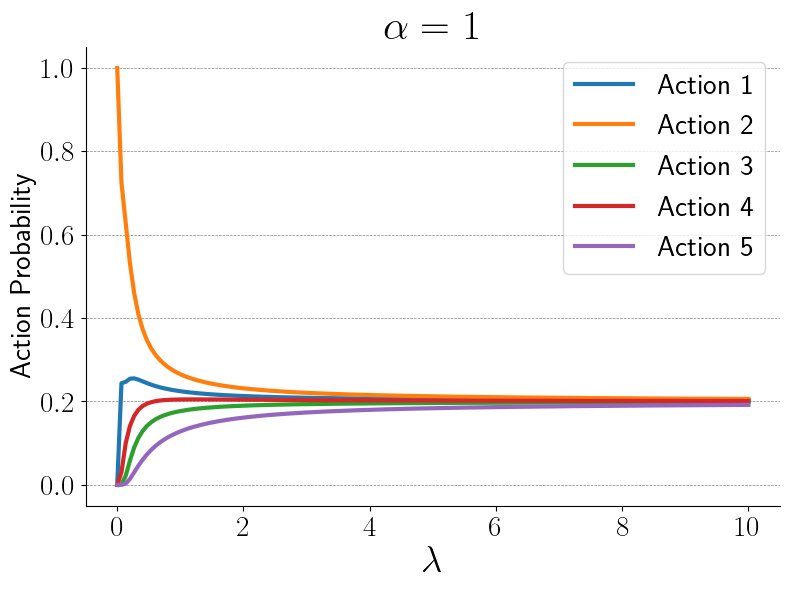

Now running Tsallis with lambda: 0.0


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 6490.07it/s]


Now running Tsallis with lambda: 0.06711409395973154


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2188.37it/s]


Now running Tsallis with lambda: 0.1342281879194631


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2163.26it/s]


Now running Tsallis with lambda: 0.20134228187919462


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1954.22it/s]


Now running Tsallis with lambda: 0.2684563758389262


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2140.86it/s]


Now running Tsallis with lambda: 0.33557046979865773


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2339.11it/s]


Now running Tsallis with lambda: 0.40268456375838924


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2326.58it/s]


Now running Tsallis with lambda: 0.4697986577181208


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2135.15it/s]


Now running Tsallis with lambda: 0.5369127516778524


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2010.32it/s]


Now running Tsallis with lambda: 0.6040268456375839


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2439.88it/s]


Now running Tsallis with lambda: 0.6711409395973155


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2229.71it/s]


Now running Tsallis with lambda: 0.738255033557047


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2081.67it/s]


Now running Tsallis with lambda: 0.8053691275167785


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2091.26it/s]


Now running Tsallis with lambda: 0.87248322147651


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1892.77it/s]


Now running Tsallis with lambda: 0.9395973154362416


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1678.04it/s]


Now running Tsallis with lambda: 1.0067114093959733


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1869.22it/s]


Now running Tsallis with lambda: 1.0738255033557047


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2326.27it/s]


Now running Tsallis with lambda: 1.1409395973154361


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2270.72it/s]


Now running Tsallis with lambda: 1.2080536912751678


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2175.56it/s]


Now running Tsallis with lambda: 1.2751677852348993


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2334.75it/s]


Now running Tsallis with lambda: 1.342281879194631


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2362.25it/s]


Now running Tsallis with lambda: 1.4093959731543624


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2344.60it/s]


Now running Tsallis with lambda: 1.476510067114094


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2199.19it/s]


Now running Tsallis with lambda: 1.5436241610738255


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2345.38it/s]


Now running Tsallis with lambda: 1.610738255033557


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2275.25it/s]


Now running Tsallis with lambda: 1.6778523489932886


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2420.80it/s]


Now running Tsallis with lambda: 1.74496644295302


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2539.68it/s]


Now running Tsallis with lambda: 1.8120805369127517


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2080.07it/s]


Now running Tsallis with lambda: 1.8791946308724832


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2094.20it/s]


Now running Tsallis with lambda: 1.9463087248322148


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2252.46it/s]


Now running Tsallis with lambda: 2.0134228187919465


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1926.55it/s]


Now running Tsallis with lambda: 2.0805369127516777


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2034.38it/s]


Now running Tsallis with lambda: 2.1476510067114094


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1931.42it/s]


Now running Tsallis with lambda: 2.214765100671141


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2014.22it/s]

Now running Tsallis with lambda: 2.2818791946308723



100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2226.06it/s]


Now running Tsallis with lambda: 2.348993288590604


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2265.79it/s]


Now running Tsallis with lambda: 2.4161073825503356


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2444.26it/s]


Now running Tsallis with lambda: 2.4832214765100673


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2679.93it/s]


Now running Tsallis with lambda: 2.5503355704697985


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2267.04it/s]


Now running Tsallis with lambda: 2.61744966442953


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2748.49it/s]


Now running Tsallis with lambda: 2.684563758389262


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2929.86it/s]


Now running Tsallis with lambda: 2.751677852348993


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2284.94it/s]


Now running Tsallis with lambda: 2.8187919463087248


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2601.40it/s]


Now running Tsallis with lambda: 2.8859060402684564


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2532.98it/s]


Now running Tsallis with lambda: 2.953020134228188


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1457.28it/s]


Now running Tsallis with lambda: 3.0201342281879193


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1955.55it/s]


Now running Tsallis with lambda: 3.087248322147651


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2573.93it/s]


Now running Tsallis with lambda: 3.1543624161073827


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1935.15it/s]


Now running Tsallis with lambda: 3.221476510067114


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1105.47it/s]


Now running Tsallis with lambda: 3.2885906040268456


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1993.24it/s]


Now running Tsallis with lambda: 3.3557046979865772


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2135.90it/s]


Now running Tsallis with lambda: 3.422818791946309


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3105.34it/s]


Now running Tsallis with lambda: 3.48993288590604


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3021.97it/s]


Now running Tsallis with lambda: 3.557046979865772


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2956.92it/s]


Now running Tsallis with lambda: 3.6241610738255035


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2768.18it/s]


Now running Tsallis with lambda: 3.691275167785235


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2924.69it/s]


Now running Tsallis with lambda: 3.7583892617449663


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2772.59it/s]


Now running Tsallis with lambda: 3.825503355704698


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2926.73it/s]


Now running Tsallis with lambda: 3.8926174496644297


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2669.97it/s]


Now running Tsallis with lambda: 3.959731543624161


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2813.77it/s]


Now running Tsallis with lambda: 4.026845637583893


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3141.03it/s]


Now running Tsallis with lambda: 4.093959731543624


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2983.62it/s]


Now running Tsallis with lambda: 4.1610738255033555


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2961.99it/s]


Now running Tsallis with lambda: 4.228187919463087


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2772.33it/s]


Now running Tsallis with lambda: 4.295302013422819


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2290.67it/s]


Now running Tsallis with lambda: 4.3624161073825505


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2902.26it/s]


Now running Tsallis with lambda: 4.429530201342282


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2548.09it/s]


Now running Tsallis with lambda: 4.496644295302014


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2082.53it/s]


Now running Tsallis with lambda: 4.563758389261745


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2160.88it/s]


Now running Tsallis with lambda: 4.630872483221476


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2288.88it/s]


Now running Tsallis with lambda: 4.697986577181208


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1921.89it/s]


Now running Tsallis with lambda: 4.76510067114094


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1911.68it/s]


Now running Tsallis with lambda: 4.832214765100671


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1849.84it/s]


Now running Tsallis with lambda: 4.899328859060403


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2451.23it/s]


Now running Tsallis with lambda: 4.966442953020135


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2004.59it/s]


Now running Tsallis with lambda: 5.033557046979865


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2367.83it/s]


Now running Tsallis with lambda: 5.100671140939597


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2119.30it/s]


Now running Tsallis with lambda: 5.167785234899329


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2152.52it/s]


Now running Tsallis with lambda: 5.23489932885906


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2282.68it/s]


Now running Tsallis with lambda: 5.302013422818792


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1190.89it/s]


Now running Tsallis with lambda: 5.369127516778524


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1469.17it/s]


Now running Tsallis with lambda: 5.436241610738255


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1253.97it/s]


Now running Tsallis with lambda: 5.503355704697986


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2563.31it/s]


Now running Tsallis with lambda: 5.570469798657718


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2283.54it/s]


Now running Tsallis with lambda: 5.6375838926174495


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2413.44it/s]


Now running Tsallis with lambda: 5.704697986577181


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2276.13it/s]


Now running Tsallis with lambda: 5.771812080536913


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1864.20it/s]


Now running Tsallis with lambda: 5.8389261744966445


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1296.68it/s]


Now running Tsallis with lambda: 5.906040268456376


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 534.80it/s]


Now running Tsallis with lambda: 5.973154362416107


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 557.44it/s]


Now running Tsallis with lambda: 6.040268456375839


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2008.39it/s]


Now running Tsallis with lambda: 6.10738255033557


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2097.37it/s]


Now running Tsallis with lambda: 6.174496644295302


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2350.13it/s]


Now running Tsallis with lambda: 6.241610738255034


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2465.76it/s]


Now running Tsallis with lambda: 6.308724832214765


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2200.56it/s]


Now running Tsallis with lambda: 6.375838926174497


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2438.03it/s]


Now running Tsallis with lambda: 6.442953020134228


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2204.52it/s]


Now running Tsallis with lambda: 6.510067114093959


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2397.98it/s]


Now running Tsallis with lambda: 6.577181208053691


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2186.44it/s]


Now running Tsallis with lambda: 6.644295302013423


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2390.83it/s]


Now running Tsallis with lambda: 6.7114093959731544


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2070.82it/s]


Now running Tsallis with lambda: 6.778523489932886


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2177.77it/s]


Now running Tsallis with lambda: 6.845637583892618


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2280.75it/s]


Now running Tsallis with lambda: 6.9127516778523495


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2203.46it/s]


Now running Tsallis with lambda: 6.97986577181208


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2217.60it/s]


Now running Tsallis with lambda: 7.046979865771812


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2130.35it/s]


Now running Tsallis with lambda: 7.114093959731544


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2371.99it/s]


Now running Tsallis with lambda: 7.181208053691275


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 392.93it/s]


Now running Tsallis with lambda: 7.248322147651007


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 372.87it/s]


Now running Tsallis with lambda: 7.315436241610739


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2883.69it/s]


Now running Tsallis with lambda: 7.38255033557047


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2894.25it/s]


Now running Tsallis with lambda: 7.449664429530201


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2978.91it/s]


Now running Tsallis with lambda: 7.516778523489933


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2396.91it/s]


Now running Tsallis with lambda: 7.583892617449664


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2381.99it/s]


Now running Tsallis with lambda: 7.651006711409396


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1651.78it/s]


Now running Tsallis with lambda: 7.718120805369128


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1359.48it/s]


Now running Tsallis with lambda: 7.785234899328859


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2323.61it/s]


Now running Tsallis with lambda: 7.852348993288591


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2127.94it/s]


Now running Tsallis with lambda: 7.919463087248322


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2054.59it/s]


Now running Tsallis with lambda: 7.9865771812080535


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2138.90it/s]


Now running Tsallis with lambda: 8.053691275167786


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2226.03it/s]


Now running Tsallis with lambda: 8.120805369127517


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2187.30it/s]


Now running Tsallis with lambda: 8.187919463087248


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2305.88it/s]


Now running Tsallis with lambda: 8.25503355704698


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2107.73it/s]


Now running Tsallis with lambda: 8.322147651006711


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2167.60it/s]


Now running Tsallis with lambda: 8.389261744966444


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 964.04it/s]


Now running Tsallis with lambda: 8.456375838926174


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2090.01it/s]


Now running Tsallis with lambda: 8.523489932885907


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2479.02it/s]


Now running Tsallis with lambda: 8.590604026845638


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2293.91it/s]


Now running Tsallis with lambda: 8.657718120805368


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2453.16it/s]


Now running Tsallis with lambda: 8.724832214765101


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2215.67it/s]


Now running Tsallis with lambda: 8.791946308724832


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2261.90it/s]


Now running Tsallis with lambda: 8.859060402684564


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2490.23it/s]


Now running Tsallis with lambda: 8.926174496644295


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2257.68it/s]


Now running Tsallis with lambda: 8.993288590604028


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2475.14it/s]


Now running Tsallis with lambda: 9.060402684563758


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1595.36it/s]


Now running Tsallis with lambda: 9.12751677852349


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2129.13it/s]


Now running Tsallis with lambda: 9.194630872483222


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2051.23it/s]


Now running Tsallis with lambda: 9.261744966442953


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1652.07it/s]


Now running Tsallis with lambda: 9.328859060402685


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2182.63it/s]


Now running Tsallis with lambda: 9.395973154362416


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1956.19it/s]


Now running Tsallis with lambda: 9.463087248322148


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1753.44it/s]


Now running Tsallis with lambda: 9.53020134228188


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 941.75it/s]


Now running Tsallis with lambda: 9.59731543624161


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1172.22it/s]


Now running Tsallis with lambda: 9.664429530201343


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2858.19it/s]


Now running Tsallis with lambda: 9.731543624161073


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2582.08it/s]


Now running Tsallis with lambda: 9.798657718120806


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2015.70it/s]


Now running Tsallis with lambda: 9.865771812080537


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1615.98it/s]


Now running Tsallis with lambda: 9.93288590604027


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1937.14it/s]


Now running Tsallis with lambda: 10.0


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1382.03it/s]


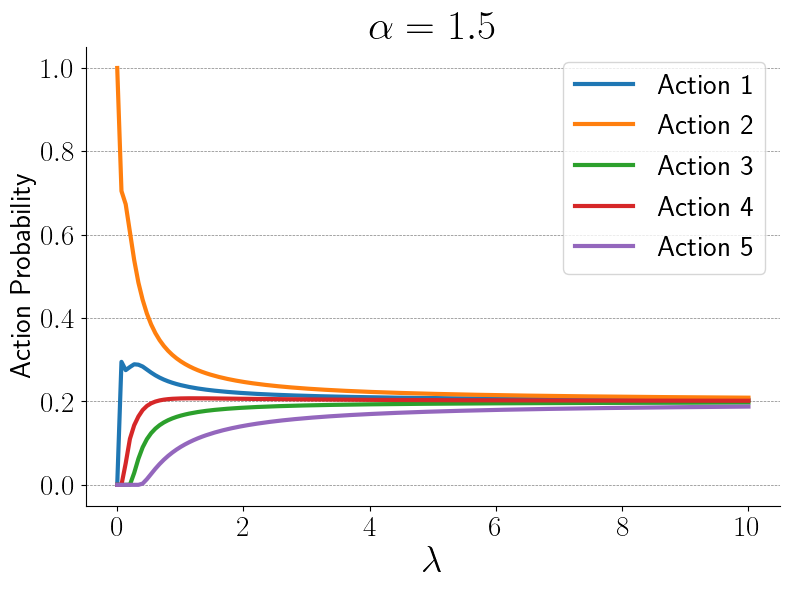

Now running Tsallis with lambda: 0.0


100%|████████████████████████████████████████| 49/49 [00:00<00:00, 10445.79it/s]


Now running Tsallis with lambda: 0.06711409395973154


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1885.13it/s]


Now running Tsallis with lambda: 0.1342281879194631


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2610.42it/s]


Now running Tsallis with lambda: 0.20134228187919462


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2955.35it/s]


Now running Tsallis with lambda: 0.2684563758389262


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3027.44it/s]


Now running Tsallis with lambda: 0.33557046979865773


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2395.77it/s]


Now running Tsallis with lambda: 0.40268456375838924


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2601.79it/s]


Now running Tsallis with lambda: 0.4697986577181208


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2527.71it/s]


Now running Tsallis with lambda: 0.5369127516778524


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2788.35it/s]


Now running Tsallis with lambda: 0.6040268456375839


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2766.91it/s]


Now running Tsallis with lambda: 0.6711409395973155


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2513.59it/s]


Now running Tsallis with lambda: 0.738255033557047


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2755.16it/s]


Now running Tsallis with lambda: 0.8053691275167785


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2632.99it/s]


Now running Tsallis with lambda: 0.87248322147651


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3001.40it/s]


Now running Tsallis with lambda: 0.9395973154362416


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2467.92it/s]


Now running Tsallis with lambda: 1.0067114093959733


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2513.43it/s]


Now running Tsallis with lambda: 1.0738255033557047


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2305.86it/s]


Now running Tsallis with lambda: 1.1409395973154361


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1775.37it/s]


Now running Tsallis with lambda: 1.2080536912751678


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1965.26it/s]


Now running Tsallis with lambda: 1.2751677852348993


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2091.96it/s]


Now running Tsallis with lambda: 1.342281879194631


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2408.23it/s]


Now running Tsallis with lambda: 1.4093959731543624


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2532.57it/s]


Now running Tsallis with lambda: 1.476510067114094


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3175.83it/s]


Now running Tsallis with lambda: 1.5436241610738255


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3308.77it/s]


Now running Tsallis with lambda: 1.610738255033557


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3097.15it/s]


Now running Tsallis with lambda: 1.6778523489932886


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3220.93it/s]


Now running Tsallis with lambda: 1.74496644295302


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3362.36it/s]


Now running Tsallis with lambda: 1.8120805369127517


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3454.83it/s]


Now running Tsallis with lambda: 1.8791946308724832


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3166.78it/s]


Now running Tsallis with lambda: 1.9463087248322148


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3311.22it/s]


Now running Tsallis with lambda: 2.0134228187919465


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1929.52it/s]


Now running Tsallis with lambda: 2.0805369127516777


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2509.96it/s]


Now running Tsallis with lambda: 2.1476510067114094


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2299.07it/s]


Now running Tsallis with lambda: 2.214765100671141


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3444.81it/s]


Now running Tsallis with lambda: 2.2818791946308723


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3433.53it/s]


Now running Tsallis with lambda: 2.348993288590604


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3137.39it/s]


Now running Tsallis with lambda: 2.4161073825503356


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2996.89it/s]


Now running Tsallis with lambda: 2.4832214765100673


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3368.15it/s]


Now running Tsallis with lambda: 2.5503355704697985


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3386.80it/s]


Now running Tsallis with lambda: 2.61744966442953


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3449.49it/s]


Now running Tsallis with lambda: 2.684563758389262


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2212.78it/s]


Now running Tsallis with lambda: 2.751677852348993


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3079.80it/s]


Now running Tsallis with lambda: 2.8187919463087248


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3307.23it/s]


Now running Tsallis with lambda: 2.8859060402684564


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3652.67it/s]


Now running Tsallis with lambda: 2.953020134228188


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3392.67it/s]


Now running Tsallis with lambda: 3.0201342281879193


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3392.44it/s]


Now running Tsallis with lambda: 3.087248322147651


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3552.47it/s]


Now running Tsallis with lambda: 3.1543624161073827


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 882.90it/s]


Now running Tsallis with lambda: 3.221476510067114


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2298.09it/s]


Now running Tsallis with lambda: 3.2885906040268456


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3271.32it/s]


Now running Tsallis with lambda: 3.3557046979865772


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3697.88it/s]


Now running Tsallis with lambda: 3.422818791946309


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3142.86it/s]


Now running Tsallis with lambda: 3.48993288590604


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1847.59it/s]


Now running Tsallis with lambda: 3.557046979865772


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3264.93it/s]


Now running Tsallis with lambda: 3.6241610738255035


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3345.88it/s]


Now running Tsallis with lambda: 3.691275167785235


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3044.21it/s]


Now running Tsallis with lambda: 3.7583892617449663


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3098.88it/s]


Now running Tsallis with lambda: 3.825503355704698


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3397.38it/s]


Now running Tsallis with lambda: 3.8926174496644297


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3462.86it/s]


Now running Tsallis with lambda: 3.959731543624161


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3895.10it/s]


Now running Tsallis with lambda: 4.026845637583893


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3679.54it/s]


Now running Tsallis with lambda: 4.093959731543624


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3587.57it/s]


Now running Tsallis with lambda: 4.1610738255033555


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3363.74it/s]


Now running Tsallis with lambda: 4.228187919463087


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3490.03it/s]


Now running Tsallis with lambda: 4.295302013422819


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3398.95it/s]


Now running Tsallis with lambda: 4.3624161073825505


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3342.62it/s]


Now running Tsallis with lambda: 4.429530201342282


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3270.18it/s]


Now running Tsallis with lambda: 4.496644295302014


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3490.80it/s]


Now running Tsallis with lambda: 4.563758389261745


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3518.89it/s]


Now running Tsallis with lambda: 4.630872483221476


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3588.94it/s]


Now running Tsallis with lambda: 4.697986577181208


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3066.70it/s]


Now running Tsallis with lambda: 4.76510067114094


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3095.94it/s]


Now running Tsallis with lambda: 4.832214765100671


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3102.06it/s]


Now running Tsallis with lambda: 4.899328859060403


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3135.62it/s]


Now running Tsallis with lambda: 4.966442953020135


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3237.52it/s]


Now running Tsallis with lambda: 5.033557046979865


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2238.67it/s]


Now running Tsallis with lambda: 5.100671140939597


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2386.28it/s]


Now running Tsallis with lambda: 5.167785234899329


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1894.81it/s]


Now running Tsallis with lambda: 5.23489932885906


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2076.64it/s]


Now running Tsallis with lambda: 5.302013422818792


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2734.23it/s]


Now running Tsallis with lambda: 5.369127516778524


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2787.06it/s]


Now running Tsallis with lambda: 5.436241610738255


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2721.45it/s]


Now running Tsallis with lambda: 5.503355704697986


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2658.71it/s]


Now running Tsallis with lambda: 5.570469798657718


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2507.03it/s]


Now running Tsallis with lambda: 5.6375838926174495


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2849.04it/s]


Now running Tsallis with lambda: 5.704697986577181


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3739.05it/s]


Now running Tsallis with lambda: 5.771812080536913


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2983.06it/s]


Now running Tsallis with lambda: 5.8389261744966445


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2519.66it/s]


Now running Tsallis with lambda: 5.906040268456376


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2211.78it/s]


Now running Tsallis with lambda: 5.973154362416107


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2912.71it/s]


Now running Tsallis with lambda: 6.040268456375839


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2526.13it/s]


Now running Tsallis with lambda: 6.10738255033557


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2505.86it/s]


Now running Tsallis with lambda: 6.174496644295302


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2915.77it/s]


Now running Tsallis with lambda: 6.241610738255034


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3203.26it/s]


Now running Tsallis with lambda: 6.308724832214765


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3448.74it/s]


Now running Tsallis with lambda: 6.375838926174497


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2866.88it/s]


Now running Tsallis with lambda: 6.442953020134228


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2488.96it/s]


Now running Tsallis with lambda: 6.510067114093959


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1809.99it/s]


Now running Tsallis with lambda: 6.577181208053691


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2193.35it/s]


Now running Tsallis with lambda: 6.644295302013423


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3188.45it/s]


Now running Tsallis with lambda: 6.7114093959731544


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2497.49it/s]


Now running Tsallis with lambda: 6.778523489932886


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2670.42it/s]


Now running Tsallis with lambda: 6.845637583892618


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2719.83it/s]


Now running Tsallis with lambda: 6.9127516778523495


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2740.50it/s]


Now running Tsallis with lambda: 6.97986577181208


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2718.75it/s]


Now running Tsallis with lambda: 7.046979865771812


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2952.63it/s]


Now running Tsallis with lambda: 7.114093959731544


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2808.54it/s]


Now running Tsallis with lambda: 7.181208053691275


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2390.36it/s]


Now running Tsallis with lambda: 7.248322147651007


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2530.58it/s]


Now running Tsallis with lambda: 7.315436241610739


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2526.97it/s]


Now running Tsallis with lambda: 7.38255033557047


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2378.38it/s]


Now running Tsallis with lambda: 7.449664429530201


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2061.95it/s]


Now running Tsallis with lambda: 7.516778523489933


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2350.91it/s]


Now running Tsallis with lambda: 7.583892617449664


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1997.95it/s]


Now running Tsallis with lambda: 7.651006711409396


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2262.85it/s]


Now running Tsallis with lambda: 7.718120805369128


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2364.18it/s]


Now running Tsallis with lambda: 7.785234899328859


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2632.86it/s]


Now running Tsallis with lambda: 7.852348993288591


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2754.20it/s]


Now running Tsallis with lambda: 7.919463087248322


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2739.11it/s]


Now running Tsallis with lambda: 7.9865771812080535


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2757.78it/s]


Now running Tsallis with lambda: 8.053691275167786


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2062.01it/s]


Now running Tsallis with lambda: 8.120805369127517


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2676.99it/s]


Now running Tsallis with lambda: 8.187919463087248


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2936.10it/s]


Now running Tsallis with lambda: 8.25503355704698


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3466.31it/s]


Now running Tsallis with lambda: 8.322147651006711


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 3393.34it/s]


Now running Tsallis with lambda: 8.389261744966444


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2966.05it/s]


Now running Tsallis with lambda: 8.456375838926174


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2550.24it/s]


Now running Tsallis with lambda: 8.523489932885907


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2768.52it/s]


Now running Tsallis with lambda: 8.590604026845638


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2878.44it/s]


Now running Tsallis with lambda: 8.657718120805368


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2637.96it/s]


Now running Tsallis with lambda: 8.724832214765101


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2261.11it/s]


Now running Tsallis with lambda: 8.791946308724832


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2313.04it/s]


Now running Tsallis with lambda: 8.859060402684564


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2802.57it/s]


Now running Tsallis with lambda: 8.926174496644295


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2677.73it/s]


Now running Tsallis with lambda: 8.993288590604028


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2136.13it/s]


Now running Tsallis with lambda: 9.060402684563758


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1477.99it/s]


Now running Tsallis with lambda: 9.12751677852349


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1975.23it/s]


Now running Tsallis with lambda: 9.194630872483222


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2115.72it/s]


Now running Tsallis with lambda: 9.261744966442953


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2656.41it/s]


Now running Tsallis with lambda: 9.328859060402685


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1683.66it/s]


Now running Tsallis with lambda: 9.395973154362416


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1107.45it/s]


Now running Tsallis with lambda: 9.463087248322148


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2466.02it/s]


Now running Tsallis with lambda: 9.53020134228188


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2638.54it/s]


Now running Tsallis with lambda: 9.59731543624161


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2504.61it/s]

Now running Tsallis with lambda: 9.664429530201343



100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2569.78it/s]


Now running Tsallis with lambda: 9.731543624161073


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2691.44it/s]


Now running Tsallis with lambda: 9.798657718120806


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2699.75it/s]


Now running Tsallis with lambda: 9.865771812080537


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2715.73it/s]


Now running Tsallis with lambda: 9.93288590604027


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2932.41it/s]


Now running Tsallis with lambda: 10.0


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 293.84it/s]


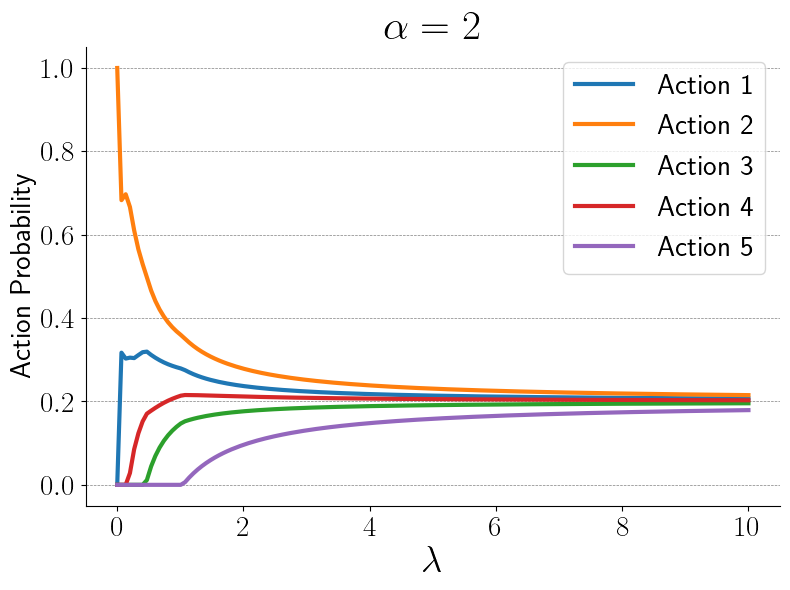

Now running Tsallis with lambda: 0.0


100%|████████████████████████████████████████| 49/49 [00:00<00:00, 11057.83it/s]


Now running Tsallis with lambda: 0.06711409395973154


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 175.50it/s]


Now running Tsallis with lambda: 0.1342281879194631


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 124.71it/s]


Now running Tsallis with lambda: 0.20134228187919462


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 102.87it/s]


Now running Tsallis with lambda: 0.2684563758389262


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 143.12it/s]


Now running Tsallis with lambda: 0.33557046979865773


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 111.47it/s]


Now running Tsallis with lambda: 0.40268456375838924


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 149.75it/s]


Now running Tsallis with lambda: 0.4697986577181208


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 163.10it/s]


Now running Tsallis with lambda: 0.5369127516778524


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 106.69it/s]


Now running Tsallis with lambda: 0.6040268456375839


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 120.84it/s]


Now running Tsallis with lambda: 0.6711409395973155


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 113.64it/s]


Now running Tsallis with lambda: 0.738255033557047


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 150.93it/s]


Now running Tsallis with lambda: 0.8053691275167785


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 194.24it/s]


Now running Tsallis with lambda: 0.87248322147651


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 163.14it/s]


Now running Tsallis with lambda: 0.9395973154362416


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 146.62it/s]


Now running Tsallis with lambda: 1.0067114093959733


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 170.23it/s]


Now running Tsallis with lambda: 1.0738255033557047


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 138.53it/s]


Now running Tsallis with lambda: 1.1409395973154361


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 187.50it/s]


Now running Tsallis with lambda: 1.2080536912751678


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 187.87it/s]


Now running Tsallis with lambda: 1.2751677852348993


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 174.20it/s]


Now running Tsallis with lambda: 1.342281879194631


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 105.50it/s]


Now running Tsallis with lambda: 1.4093959731543624


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 156.19it/s]


Now running Tsallis with lambda: 1.476510067114094


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 186.16it/s]


Now running Tsallis with lambda: 1.5436241610738255


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 192.03it/s]


Now running Tsallis with lambda: 1.610738255033557


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 187.06it/s]


Now running Tsallis with lambda: 1.6778523489932886


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 192.37it/s]


Now running Tsallis with lambda: 1.74496644295302


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 189.45it/s]


Now running Tsallis with lambda: 1.8120805369127517


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 170.14it/s]


Now running Tsallis with lambda: 1.8791946308724832


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 116.91it/s]


Now running Tsallis with lambda: 1.9463087248322148


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 146.61it/s]


Now running Tsallis with lambda: 2.0134228187919465


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 188.90it/s]


Now running Tsallis with lambda: 2.0805369127516777


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 215.53it/s]


Now running Tsallis with lambda: 2.1476510067114094


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 176.83it/s]


Now running Tsallis with lambda: 2.214765100671141


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 181.71it/s]


Now running Tsallis with lambda: 2.2818791946308723


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 177.85it/s]


Now running Tsallis with lambda: 2.348993288590604


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 175.68it/s]


Now running Tsallis with lambda: 2.4161073825503356


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 171.15it/s]


Now running Tsallis with lambda: 2.4832214765100673


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 173.48it/s]


Now running Tsallis with lambda: 2.5503355704697985


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 189.87it/s]


Now running Tsallis with lambda: 2.61744966442953


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 178.57it/s]


Now running Tsallis with lambda: 2.684563758389262


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 162.90it/s]


Now running Tsallis with lambda: 2.751677852348993


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 116.07it/s]


Now running Tsallis with lambda: 2.8187919463087248


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 188.63it/s]


Now running Tsallis with lambda: 2.8859060402684564


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 195.64it/s]


Now running Tsallis with lambda: 2.953020134228188


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 216.36it/s]


Now running Tsallis with lambda: 3.0201342281879193


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 150.85it/s]


Now running Tsallis with lambda: 3.087248322147651


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 163.30it/s]


Now running Tsallis with lambda: 3.1543624161073827


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 93.60it/s]


Now running Tsallis with lambda: 3.221476510067114


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 85.68it/s]


Now running Tsallis with lambda: 3.2885906040268456


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 118.40it/s]


Now running Tsallis with lambda: 3.3557046979865772


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 148.48it/s]


Now running Tsallis with lambda: 3.422818791946309


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 135.17it/s]


Now running Tsallis with lambda: 3.48993288590604


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 71.45it/s]


Now running Tsallis with lambda: 3.557046979865772


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 115.04it/s]


Now running Tsallis with lambda: 3.6241610738255035


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 195.21it/s]


Now running Tsallis with lambda: 3.691275167785235


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 134.16it/s]


Now running Tsallis with lambda: 3.7583892617449663


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 85.10it/s]


Now running Tsallis with lambda: 3.825503355704698


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 98.53it/s]


Now running Tsallis with lambda: 3.8926174496644297


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 108.93it/s]


Now running Tsallis with lambda: 3.959731543624161


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 99.02it/s]


Now running Tsallis with lambda: 4.026845637583893


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 91.99it/s]


Now running Tsallis with lambda: 4.093959731543624


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 89.76it/s]


Now running Tsallis with lambda: 4.1610738255033555


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 88.89it/s]


Now running Tsallis with lambda: 4.228187919463087


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 79.27it/s]


Now running Tsallis with lambda: 4.295302013422819


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 72.47it/s]


Now running Tsallis with lambda: 4.3624161073825505


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 95.44it/s]


Now running Tsallis with lambda: 4.429530201342282


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 90.96it/s]


Now running Tsallis with lambda: 4.496644295302014


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 87.06it/s]


Now running Tsallis with lambda: 4.563758389261745


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 86.50it/s]


Now running Tsallis with lambda: 4.630872483221476


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 74.14it/s]


Now running Tsallis with lambda: 4.697986577181208


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 83.75it/s]


Now running Tsallis with lambda: 4.76510067114094


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 92.33it/s]


Now running Tsallis with lambda: 4.832214765100671


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 73.49it/s]


Now running Tsallis with lambda: 4.899328859060403


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 54.92it/s]


Now running Tsallis with lambda: 4.966442953020135


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 82.21it/s]


Now running Tsallis with lambda: 5.033557046979865


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 68.74it/s]


Now running Tsallis with lambda: 5.100671140939597


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 64.36it/s]


Now running Tsallis with lambda: 5.167785234899329


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 64.92it/s]


Now running Tsallis with lambda: 5.23489932885906


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 80.08it/s]


Now running Tsallis with lambda: 5.302013422818792


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 111.47it/s]


Now running Tsallis with lambda: 5.369127516778524


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 77.63it/s]


Now running Tsallis with lambda: 5.436241610738255


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 138.47it/s]


Now running Tsallis with lambda: 5.503355704697986


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 84.38it/s]


Now running Tsallis with lambda: 5.570469798657718


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 84.98it/s]


Now running Tsallis with lambda: 5.6375838926174495


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 98.24it/s]


Now running Tsallis with lambda: 5.704697986577181


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 99.46it/s]


Now running Tsallis with lambda: 5.771812080536913


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 102.48it/s]


Now running Tsallis with lambda: 5.8389261744966445


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 63.34it/s]


Now running Tsallis with lambda: 5.906040268456376


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 55.23it/s]


Now running Tsallis with lambda: 5.973154362416107


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 53.79it/s]


Now running Tsallis with lambda: 6.040268456375839


100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 40.14it/s]


Now running Tsallis with lambda: 6.10738255033557


100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 41.99it/s]


Now running Tsallis with lambda: 6.174496644295302


100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 45.95it/s]


Now running Tsallis with lambda: 6.241610738255034


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 67.03it/s]


Now running Tsallis with lambda: 6.308724832214765


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 64.36it/s]


Now running Tsallis with lambda: 6.375838926174497


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 72.59it/s]


Now running Tsallis with lambda: 6.442953020134228


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 84.47it/s]


Now running Tsallis with lambda: 6.510067114093959


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 56.11it/s]


Now running Tsallis with lambda: 6.577181208053691


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 61.05it/s]


Now running Tsallis with lambda: 6.644295302013423


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 57.47it/s]


Now running Tsallis with lambda: 6.7114093959731544


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 67.47it/s]


Now running Tsallis with lambda: 6.778523489932886


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 85.02it/s]


Now running Tsallis with lambda: 6.845637583892618


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 118.06it/s]


Now running Tsallis with lambda: 6.9127516778523495


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 95.35it/s]


Now running Tsallis with lambda: 6.97986577181208


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 92.88it/s]


Now running Tsallis with lambda: 7.046979865771812


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 204.59it/s]


Now running Tsallis with lambda: 7.114093959731544


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 177.03it/s]


Now running Tsallis with lambda: 7.181208053691275


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 104.14it/s]


Now running Tsallis with lambda: 7.248322147651007


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 114.12it/s]


Now running Tsallis with lambda: 7.315436241610739


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 78.92it/s]


Now running Tsallis with lambda: 7.38255033557047


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 188.58it/s]


Now running Tsallis with lambda: 7.449664429530201


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 129.18it/s]


Now running Tsallis with lambda: 7.516778523489933


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 96.30it/s]


Now running Tsallis with lambda: 7.583892617449664


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 71.92it/s]


Now running Tsallis with lambda: 7.651006711409396


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 155.17it/s]


Now running Tsallis with lambda: 7.718120805369128


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 102.36it/s]


Now running Tsallis with lambda: 7.785234899328859


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 203.04it/s]


Now running Tsallis with lambda: 7.852348993288591


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 199.16it/s]


Now running Tsallis with lambda: 7.919463087248322


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 195.28it/s]


Now running Tsallis with lambda: 7.9865771812080535


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 204.47it/s]


Now running Tsallis with lambda: 8.053691275167786


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 202.12it/s]


Now running Tsallis with lambda: 8.120805369127517


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 188.88it/s]


Now running Tsallis with lambda: 8.187919463087248


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 126.13it/s]


Now running Tsallis with lambda: 8.25503355704698


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 211.94it/s]


Now running Tsallis with lambda: 8.322147651006711


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 174.23it/s]


Now running Tsallis with lambda: 8.389261744966444


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 182.17it/s]


Now running Tsallis with lambda: 8.456375838926174


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 169.62it/s]


Now running Tsallis with lambda: 8.523489932885907


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 165.12it/s]


Now running Tsallis with lambda: 8.590604026845638


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 193.19it/s]


Now running Tsallis with lambda: 8.657718120805368


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 190.66it/s]


Now running Tsallis with lambda: 8.724832214765101


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 175.58it/s]


Now running Tsallis with lambda: 8.791946308724832


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 69.09it/s]


Now running Tsallis with lambda: 8.859060402684564


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 111.64it/s]


Now running Tsallis with lambda: 8.926174496644295


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 131.22it/s]


Now running Tsallis with lambda: 8.993288590604028


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 162.73it/s]


Now running Tsallis with lambda: 9.060402684563758


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 95.22it/s]


Now running Tsallis with lambda: 9.12751677852349


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 199.21it/s]


Now running Tsallis with lambda: 9.194630872483222


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 130.14it/s]


Now running Tsallis with lambda: 9.261744966442953


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 169.98it/s]


Now running Tsallis with lambda: 9.328859060402685


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 191.84it/s]


Now running Tsallis with lambda: 9.395973154362416


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 76.40it/s]


Now running Tsallis with lambda: 9.463087248322148


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 104.46it/s]


Now running Tsallis with lambda: 9.53020134228188


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 122.65it/s]


Now running Tsallis with lambda: 9.59731543624161


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 120.07it/s]


Now running Tsallis with lambda: 9.664429530201343


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 100.48it/s]


Now running Tsallis with lambda: 9.731543624161073


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 81.37it/s]


Now running Tsallis with lambda: 9.798657718120806


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 73.54it/s]


Now running Tsallis with lambda: 9.865771812080537


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 56.76it/s]


Now running Tsallis with lambda: 9.93288590604027


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 140.86it/s]


Now running Tsallis with lambda: 10.0


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 92.32it/s]


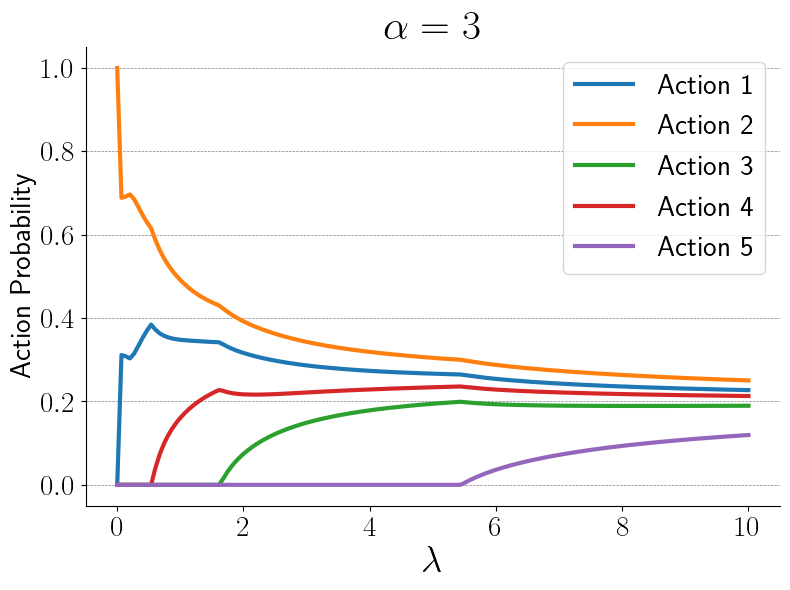

Now running Tsallis with lambda: 0.0


100%|████████████████████████████████████████| 49/49 [00:00<00:00, 15609.97it/s]


Now running Tsallis with lambda: 0.06711409395973154


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 106.33it/s]


Now running Tsallis with lambda: 0.1342281879194631


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 77.07it/s]


Now running Tsallis with lambda: 0.20134228187919462


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 70.01it/s]


Now running Tsallis with lambda: 0.2684563758389262


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 70.26it/s]


Now running Tsallis with lambda: 0.33557046979865773


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 75.47it/s]


Now running Tsallis with lambda: 0.40268456375838924


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 65.96it/s]


Now running Tsallis with lambda: 0.4697986577181208


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 61.60it/s]


Now running Tsallis with lambda: 0.5369127516778524


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 54.50it/s]


Now running Tsallis with lambda: 0.6040268456375839


100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 46.24it/s]


Now running Tsallis with lambda: 0.6711409395973155


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 60.80it/s]


Now running Tsallis with lambda: 0.738255033557047


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 111.38it/s]


Now running Tsallis with lambda: 0.8053691275167785


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 140.27it/s]


Now running Tsallis with lambda: 0.87248322147651


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 86.91it/s]


Now running Tsallis with lambda: 0.9395973154362416


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 92.95it/s]


Now running Tsallis with lambda: 1.0067114093959733


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 103.35it/s]


Now running Tsallis with lambda: 1.0738255033557047


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 85.93it/s]


Now running Tsallis with lambda: 1.1409395973154361


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 93.51it/s]


Now running Tsallis with lambda: 1.2080536912751678


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 84.25it/s]


Now running Tsallis with lambda: 1.2751677852348993


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 106.39it/s]


Now running Tsallis with lambda: 1.342281879194631


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 72.18it/s]


Now running Tsallis with lambda: 1.4093959731543624


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 59.38it/s]


Now running Tsallis with lambda: 1.476510067114094


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 86.92it/s]


Now running Tsallis with lambda: 1.5436241610738255


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 60.93it/s]


Now running Tsallis with lambda: 1.610738255033557


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 81.55it/s]


Now running Tsallis with lambda: 1.6778523489932886


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 76.90it/s]


Now running Tsallis with lambda: 1.74496644295302


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 50.21it/s]


Now running Tsallis with lambda: 1.8120805369127517


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 56.05it/s]


Now running Tsallis with lambda: 1.8791946308724832


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 63.96it/s]


Now running Tsallis with lambda: 1.9463087248322148


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 65.00it/s]


Now running Tsallis with lambda: 2.0134228187919465


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 126.19it/s]


Now running Tsallis with lambda: 2.0805369127516777


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 125.31it/s]


Now running Tsallis with lambda: 2.1476510067114094


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 104.66it/s]


Now running Tsallis with lambda: 2.214765100671141


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 89.13it/s]


Now running Tsallis with lambda: 2.2818791946308723


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 86.57it/s]


Now running Tsallis with lambda: 2.348993288590604


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 69.43it/s]


Now running Tsallis with lambda: 2.4161073825503356


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 199.26it/s]


Now running Tsallis with lambda: 2.4832214765100673


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 173.32it/s]


Now running Tsallis with lambda: 2.5503355704697985


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 162.41it/s]


Now running Tsallis with lambda: 2.61744966442953


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 192.07it/s]


Now running Tsallis with lambda: 2.684563758389262


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 194.62it/s]


Now running Tsallis with lambda: 2.751677852348993


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 118.46it/s]


Now running Tsallis with lambda: 2.8187919463087248


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 139.53it/s]


Now running Tsallis with lambda: 2.8859060402684564


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 195.93it/s]


Now running Tsallis with lambda: 2.953020134228188


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 200.33it/s]


Now running Tsallis with lambda: 3.0201342281879193


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 180.80it/s]


Now running Tsallis with lambda: 3.087248322147651


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 188.23it/s]


Now running Tsallis with lambda: 3.1543624161073827


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 183.06it/s]


Now running Tsallis with lambda: 3.221476510067114


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 198.16it/s]


Now running Tsallis with lambda: 3.2885906040268456


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 100.79it/s]


Now running Tsallis with lambda: 3.3557046979865772


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 195.49it/s]


Now running Tsallis with lambda: 3.422818791946309


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 159.35it/s]


Now running Tsallis with lambda: 3.48993288590604


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 116.83it/s]


Now running Tsallis with lambda: 3.557046979865772


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 179.10it/s]


Now running Tsallis with lambda: 3.6241610738255035


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 199.13it/s]


Now running Tsallis with lambda: 3.691275167785235


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 132.63it/s]


Now running Tsallis with lambda: 3.7583892617449663


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 208.24it/s]


Now running Tsallis with lambda: 3.825503355704698


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 221.03it/s]


Now running Tsallis with lambda: 3.8926174496644297


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 226.19it/s]


Now running Tsallis with lambda: 3.959731543624161


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 204.03it/s]


Now running Tsallis with lambda: 4.026845637583893


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 216.31it/s]


Now running Tsallis with lambda: 4.093959731543624


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 234.00it/s]


Now running Tsallis with lambda: 4.1610738255033555


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 240.69it/s]


Now running Tsallis with lambda: 4.228187919463087


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 161.06it/s]


Now running Tsallis with lambda: 4.295302013422819


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 149.39it/s]


Now running Tsallis with lambda: 4.3624161073825505


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 158.79it/s]


Now running Tsallis with lambda: 4.429530201342282


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 231.66it/s]


Now running Tsallis with lambda: 4.496644295302014


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 210.88it/s]


Now running Tsallis with lambda: 4.563758389261745


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 196.22it/s]


Now running Tsallis with lambda: 4.630872483221476


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 114.39it/s]


Now running Tsallis with lambda: 4.697986577181208


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 202.27it/s]


Now running Tsallis with lambda: 4.76510067114094


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 152.53it/s]


Now running Tsallis with lambda: 4.832214765100671


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 207.08it/s]


Now running Tsallis with lambda: 4.899328859060403


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 223.88it/s]


Now running Tsallis with lambda: 4.966442953020135


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 218.96it/s]


Now running Tsallis with lambda: 5.033557046979865


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 197.44it/s]


Now running Tsallis with lambda: 5.100671140939597


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 223.27it/s]


Now running Tsallis with lambda: 5.167785234899329


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 221.94it/s]


Now running Tsallis with lambda: 5.23489932885906


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 235.17it/s]


Now running Tsallis with lambda: 5.302013422818792


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 228.95it/s]


Now running Tsallis with lambda: 5.369127516778524


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 191.42it/s]


Now running Tsallis with lambda: 5.436241610738255


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 215.79it/s]


Now running Tsallis with lambda: 5.503355704697986


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 173.67it/s]


Now running Tsallis with lambda: 5.570469798657718


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 163.31it/s]


Now running Tsallis with lambda: 5.6375838926174495


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 220.23it/s]


Now running Tsallis with lambda: 5.704697986577181


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 131.05it/s]


Now running Tsallis with lambda: 5.771812080536913


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 158.12it/s]


Now running Tsallis with lambda: 5.8389261744966445


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 174.95it/s]


Now running Tsallis with lambda: 5.906040268456376


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 132.74it/s]


Now running Tsallis with lambda: 5.973154362416107


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 201.93it/s]


Now running Tsallis with lambda: 6.040268456375839


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 177.54it/s]


Now running Tsallis with lambda: 6.10738255033557


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 195.08it/s]


Now running Tsallis with lambda: 6.174496644295302


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 209.99it/s]


Now running Tsallis with lambda: 6.241610738255034


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 197.99it/s]


Now running Tsallis with lambda: 6.308724832214765


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 164.39it/s]


Now running Tsallis with lambda: 6.375838926174497


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 166.90it/s]


Now running Tsallis with lambda: 6.442953020134228


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 179.95it/s]


Now running Tsallis with lambda: 6.510067114093959


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 186.80it/s]


Now running Tsallis with lambda: 6.577181208053691


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 156.18it/s]


Now running Tsallis with lambda: 6.644295302013423


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 182.06it/s]


Now running Tsallis with lambda: 6.7114093959731544


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 181.79it/s]


Now running Tsallis with lambda: 6.778523489932886


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 187.43it/s]


Now running Tsallis with lambda: 6.845637583892618


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 177.79it/s]


Now running Tsallis with lambda: 6.9127516778523495


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 185.21it/s]


Now running Tsallis with lambda: 6.97986577181208


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 175.90it/s]


Now running Tsallis with lambda: 7.046979865771812


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 173.58it/s]


Now running Tsallis with lambda: 7.114093959731544


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 164.22it/s]


Now running Tsallis with lambda: 7.181208053691275


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 196.40it/s]


Now running Tsallis with lambda: 7.248322147651007


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 135.78it/s]


Now running Tsallis with lambda: 7.315436241610739


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 193.31it/s]


Now running Tsallis with lambda: 7.38255033557047


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 172.38it/s]


Now running Tsallis with lambda: 7.449664429530201


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 158.63it/s]


Now running Tsallis with lambda: 7.516778523489933


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 105.99it/s]


Now running Tsallis with lambda: 7.583892617449664


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 161.15it/s]


Now running Tsallis with lambda: 7.651006711409396


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 149.68it/s]


Now running Tsallis with lambda: 7.718120805369128


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 187.17it/s]


Now running Tsallis with lambda: 7.785234899328859


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 185.56it/s]


Now running Tsallis with lambda: 7.852348993288591


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 103.21it/s]


Now running Tsallis with lambda: 7.919463087248322


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 165.71it/s]


Now running Tsallis with lambda: 7.9865771812080535


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 154.21it/s]


Now running Tsallis with lambda: 8.053691275167786


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 172.44it/s]


Now running Tsallis with lambda: 8.120805369127517


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 169.32it/s]


Now running Tsallis with lambda: 8.187919463087248


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 182.98it/s]


Now running Tsallis with lambda: 8.25503355704698


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 93.20it/s]


Now running Tsallis with lambda: 8.322147651006711


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 159.89it/s]


Now running Tsallis with lambda: 8.389261744966444


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 167.98it/s]


Now running Tsallis with lambda: 8.456375838926174


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 179.59it/s]


Now running Tsallis with lambda: 8.523489932885907


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 187.15it/s]


Now running Tsallis with lambda: 8.590604026845638


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 179.96it/s]


Now running Tsallis with lambda: 8.657718120805368


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 109.35it/s]


Now running Tsallis with lambda: 8.724832214765101


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 178.08it/s]


Now running Tsallis with lambda: 8.791946308724832


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 165.33it/s]


Now running Tsallis with lambda: 8.859060402684564


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 175.98it/s]


Now running Tsallis with lambda: 8.926174496644295


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 188.33it/s]


Now running Tsallis with lambda: 8.993288590604028


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 183.99it/s]


Now running Tsallis with lambda: 9.060402684563758


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 106.08it/s]


Now running Tsallis with lambda: 9.12751677852349


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 171.07it/s]


Now running Tsallis with lambda: 9.194630872483222


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 144.67it/s]


Now running Tsallis with lambda: 9.261744966442953


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 182.48it/s]


Now running Tsallis with lambda: 9.328859060402685


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 231.31it/s]


Now running Tsallis with lambda: 9.395973154362416


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 115.76it/s]


Now running Tsallis with lambda: 9.463087248322148


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 218.10it/s]


Now running Tsallis with lambda: 9.53020134228188


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 213.95it/s]


Now running Tsallis with lambda: 9.59731543624161


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 220.07it/s]


Now running Tsallis with lambda: 9.664429530201343


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 220.37it/s]


Now running Tsallis with lambda: 9.731543624161073


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 235.63it/s]


Now running Tsallis with lambda: 9.798657718120806


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 118.22it/s]


Now running Tsallis with lambda: 9.865771812080537


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 196.36it/s]


Now running Tsallis with lambda: 9.93288590604027


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 222.53it/s]


Now running Tsallis with lambda: 10.0


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 240.21it/s]


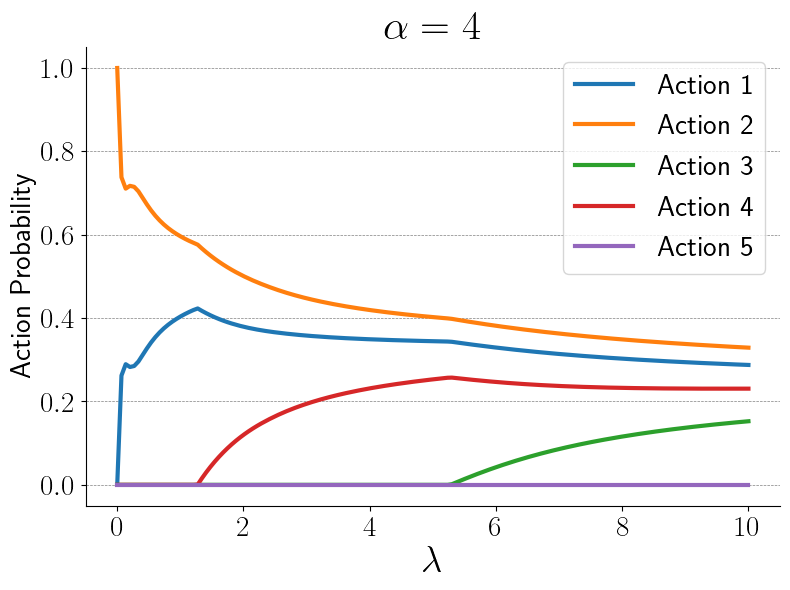

Now running Tsallis with lambda: 0.0


100%|████████████████████████████████████████| 49/49 [00:00<00:00, 18249.06it/s]


Now running Tsallis with lambda: 0.06711409395973154


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 182.92it/s]


Now running Tsallis with lambda: 0.1342281879194631


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 239.81it/s]


Now running Tsallis with lambda: 0.20134228187919462


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 224.16it/s]


Now running Tsallis with lambda: 0.2684563758389262


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 225.83it/s]


Now running Tsallis with lambda: 0.33557046979865773


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 239.07it/s]


Now running Tsallis with lambda: 0.40268456375838924


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 174.44it/s]


Now running Tsallis with lambda: 0.4697986577181208


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 159.49it/s]


Now running Tsallis with lambda: 0.5369127516778524


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 230.54it/s]


Now running Tsallis with lambda: 0.6040268456375839


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 241.63it/s]


Now running Tsallis with lambda: 0.6711409395973155


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 233.30it/s]


Now running Tsallis with lambda: 0.738255033557047


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 236.42it/s]


Now running Tsallis with lambda: 0.8053691275167785


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 123.35it/s]


Now running Tsallis with lambda: 0.87248322147651


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 238.91it/s]


Now running Tsallis with lambda: 0.9395973154362416


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 229.82it/s]


Now running Tsallis with lambda: 1.0067114093959733


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 242.01it/s]


Now running Tsallis with lambda: 1.0738255033557047


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 237.07it/s]


Now running Tsallis with lambda: 1.1409395973154361


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 228.45it/s]


Now running Tsallis with lambda: 1.2080536912751678


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 127.37it/s]


Now running Tsallis with lambda: 1.2751677852348993


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 236.88it/s]


Now running Tsallis with lambda: 1.342281879194631


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 204.24it/s]


Now running Tsallis with lambda: 1.4093959731543624


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 247.49it/s]


Now running Tsallis with lambda: 1.476510067114094


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 224.07it/s]


Now running Tsallis with lambda: 1.5436241610738255


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 239.36it/s]


Now running Tsallis with lambda: 1.610738255033557


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 137.68it/s]


Now running Tsallis with lambda: 1.6778523489932886


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 248.02it/s]


Now running Tsallis with lambda: 1.74496644295302


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 235.53it/s]


Now running Tsallis with lambda: 1.8120805369127517


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 232.26it/s]


Now running Tsallis with lambda: 1.8791946308724832


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 240.47it/s]


Now running Tsallis with lambda: 1.9463087248322148


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 210.20it/s]


Now running Tsallis with lambda: 2.0134228187919465


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 147.15it/s]


Now running Tsallis with lambda: 2.0805369127516777


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 226.71it/s]


Now running Tsallis with lambda: 2.1476510067114094


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 238.45it/s]


Now running Tsallis with lambda: 2.214765100671141


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 241.40it/s]


Now running Tsallis with lambda: 2.2818791946308723


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 230.85it/s]


Now running Tsallis with lambda: 2.348993288590604


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 242.65it/s]


Now running Tsallis with lambda: 2.4161073825503356


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 112.56it/s]


Now running Tsallis with lambda: 2.4832214765100673


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 158.69it/s]


Now running Tsallis with lambda: 2.5503355704697985


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 231.93it/s]


Now running Tsallis with lambda: 2.61744966442953


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 234.55it/s]


Now running Tsallis with lambda: 2.684563758389262


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 220.80it/s]


Now running Tsallis with lambda: 2.751677852348993


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 118.66it/s]


Now running Tsallis with lambda: 2.8187919463087248


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 240.15it/s]


Now running Tsallis with lambda: 2.8859060402684564


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 246.83it/s]


Now running Tsallis with lambda: 2.953020134228188


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 233.28it/s]


Now running Tsallis with lambda: 3.0201342281879193


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 220.94it/s]


Now running Tsallis with lambda: 3.087248322147651


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 135.43it/s]


Now running Tsallis with lambda: 3.1543624161073827


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 195.04it/s]


Now running Tsallis with lambda: 3.221476510067114


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 248.37it/s]


Now running Tsallis with lambda: 3.2885906040268456


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 223.08it/s]


Now running Tsallis with lambda: 3.3557046979865772


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 234.95it/s]


Now running Tsallis with lambda: 3.422818791946309


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 241.66it/s]


Now running Tsallis with lambda: 3.48993288590604


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 134.00it/s]


Now running Tsallis with lambda: 3.557046979865772


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 160.90it/s]


Now running Tsallis with lambda: 3.6241610738255035


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 231.54it/s]


Now running Tsallis with lambda: 3.691275167785235


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 237.22it/s]


Now running Tsallis with lambda: 3.7583892617449663


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 229.15it/s]


Now running Tsallis with lambda: 3.825503355704698


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 242.12it/s]


Now running Tsallis with lambda: 3.8926174496644297


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 125.92it/s]


Now running Tsallis with lambda: 3.959731543624161


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 239.05it/s]


Now running Tsallis with lambda: 4.026845637583893


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 231.16it/s]


Now running Tsallis with lambda: 4.093959731543624


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 244.62it/s]


Now running Tsallis with lambda: 4.1610738255033555


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 224.28it/s]


Now running Tsallis with lambda: 4.228187919463087


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 225.44it/s]


Now running Tsallis with lambda: 4.295302013422819


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 130.15it/s]


Now running Tsallis with lambda: 4.3624161073825505


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 186.58it/s]


Now running Tsallis with lambda: 4.429530201342282


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 186.97it/s]


Now running Tsallis with lambda: 4.496644295302014


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 230.64it/s]


Now running Tsallis with lambda: 4.563758389261745


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 164.70it/s]


Now running Tsallis with lambda: 4.630872483221476


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 93.67it/s]


Now running Tsallis with lambda: 4.697986577181208


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 146.47it/s]


Now running Tsallis with lambda: 4.76510067114094


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 219.02it/s]


Now running Tsallis with lambda: 4.832214765100671


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 194.48it/s]


Now running Tsallis with lambda: 4.899328859060403


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 226.96it/s]


Now running Tsallis with lambda: 4.966442953020135


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 201.42it/s]


Now running Tsallis with lambda: 5.033557046979865


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 91.37it/s]


Now running Tsallis with lambda: 5.100671140939597


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 196.82it/s]


Now running Tsallis with lambda: 5.167785234899329


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 201.73it/s]


Now running Tsallis with lambda: 5.23489932885906


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 209.21it/s]


Now running Tsallis with lambda: 5.302013422818792


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 192.83it/s]


Now running Tsallis with lambda: 5.369127516778524


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 175.50it/s]


Now running Tsallis with lambda: 5.436241610738255


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 142.16it/s]


Now running Tsallis with lambda: 5.503355704697986


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 107.83it/s]


Now running Tsallis with lambda: 5.570469798657718


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 124.50it/s]


Now running Tsallis with lambda: 5.6375838926174495


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 154.79it/s]


Now running Tsallis with lambda: 5.704697986577181


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 179.05it/s]


Now running Tsallis with lambda: 5.771812080536913


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 89.29it/s]


Now running Tsallis with lambda: 5.8389261744966445


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 179.17it/s]


Now running Tsallis with lambda: 5.906040268456376


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 181.03it/s]


Now running Tsallis with lambda: 5.973154362416107


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 147.33it/s]


Now running Tsallis with lambda: 6.040268456375839


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 225.04it/s]


Now running Tsallis with lambda: 6.10738255033557


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 204.05it/s]


Now running Tsallis with lambda: 6.174496644295302


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 125.60it/s]


Now running Tsallis with lambda: 6.241610738255034


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 210.37it/s]


Now running Tsallis with lambda: 6.308724832214765


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 169.28it/s]


Now running Tsallis with lambda: 6.375838926174497


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 100.36it/s]


Now running Tsallis with lambda: 6.442953020134228


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 127.14it/s]


Now running Tsallis with lambda: 6.510067114093959


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 93.87it/s]


Now running Tsallis with lambda: 6.577181208053691


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 179.43it/s]


Now running Tsallis with lambda: 6.644295302013423


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 220.50it/s]


Now running Tsallis with lambda: 6.7114093959731544


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 235.61it/s]


Now running Tsallis with lambda: 6.778523489932886


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 130.39it/s]


Now running Tsallis with lambda: 6.845637583892618


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 100.13it/s]


Now running Tsallis with lambda: 6.9127516778523495


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 71.95it/s]


Now running Tsallis with lambda: 6.97986577181208


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 103.67it/s]


Now running Tsallis with lambda: 7.046979865771812


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 97.43it/s]


Now running Tsallis with lambda: 7.114093959731544


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 76.85it/s]


Now running Tsallis with lambda: 7.181208053691275


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 88.06it/s]


Now running Tsallis with lambda: 7.248322147651007


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 112.82it/s]


Now running Tsallis with lambda: 7.315436241610739


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 179.24it/s]


Now running Tsallis with lambda: 7.38255033557047


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 157.79it/s]


Now running Tsallis with lambda: 7.449664429530201


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 181.59it/s]


Now running Tsallis with lambda: 7.516778523489933


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 178.44it/s]


Now running Tsallis with lambda: 7.583892617449664


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 119.27it/s]


Now running Tsallis with lambda: 7.651006711409396


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 196.45it/s]


Now running Tsallis with lambda: 7.718120805369128


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 179.58it/s]


Now running Tsallis with lambda: 7.785234899328859


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 101.52it/s]


Now running Tsallis with lambda: 7.852348993288591


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 227.71it/s]


Now running Tsallis with lambda: 7.919463087248322


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 144.33it/s]


Now running Tsallis with lambda: 7.9865771812080535


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 181.54it/s]


Now running Tsallis with lambda: 8.053691275167786


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 209.86it/s]


Now running Tsallis with lambda: 8.120805369127517


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 229.62it/s]


Now running Tsallis with lambda: 8.187919463087248


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 228.06it/s]


Now running Tsallis with lambda: 8.25503355704698


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 230.47it/s]


Now running Tsallis with lambda: 8.322147651006711


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 116.20it/s]


Now running Tsallis with lambda: 8.389261744966444


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 193.37it/s]


Now running Tsallis with lambda: 8.456375838926174


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 210.62it/s]


Now running Tsallis with lambda: 8.523489932885907


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 222.04it/s]


Now running Tsallis with lambda: 8.590604026845638


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 213.74it/s]


Now running Tsallis with lambda: 8.657718120805368


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 128.00it/s]


Now running Tsallis with lambda: 8.724832214765101


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 227.15it/s]


Now running Tsallis with lambda: 8.791946308724832


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 247.43it/s]


Now running Tsallis with lambda: 8.859060402684564


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 186.44it/s]


Now running Tsallis with lambda: 8.926174496644295


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 172.85it/s]


Now running Tsallis with lambda: 8.993288590604028


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 135.57it/s]


Now running Tsallis with lambda: 9.060402684563758


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 206.42it/s]


Now running Tsallis with lambda: 9.12751677852349


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 98.38it/s]


Now running Tsallis with lambda: 9.194630872483222


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 207.61it/s]


Now running Tsallis with lambda: 9.261744966442953


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 189.92it/s]


Now running Tsallis with lambda: 9.328859060402685


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 190.62it/s]


Now running Tsallis with lambda: 9.395973154362416


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 185.73it/s]


Now running Tsallis with lambda: 9.463087248322148


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 219.72it/s]


Now running Tsallis with lambda: 9.53020134228188


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 108.92it/s]


Now running Tsallis with lambda: 9.59731543624161


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 171.64it/s]


Now running Tsallis with lambda: 9.664429530201343


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 159.64it/s]


Now running Tsallis with lambda: 9.731543624161073


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 196.44it/s]


Now running Tsallis with lambda: 9.798657718120806


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 149.64it/s]


Now running Tsallis with lambda: 9.865771812080537


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 179.94it/s]


Now running Tsallis with lambda: 9.93288590604027


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 127.15it/s]


Now running Tsallis with lambda: 10.0


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 191.56it/s]


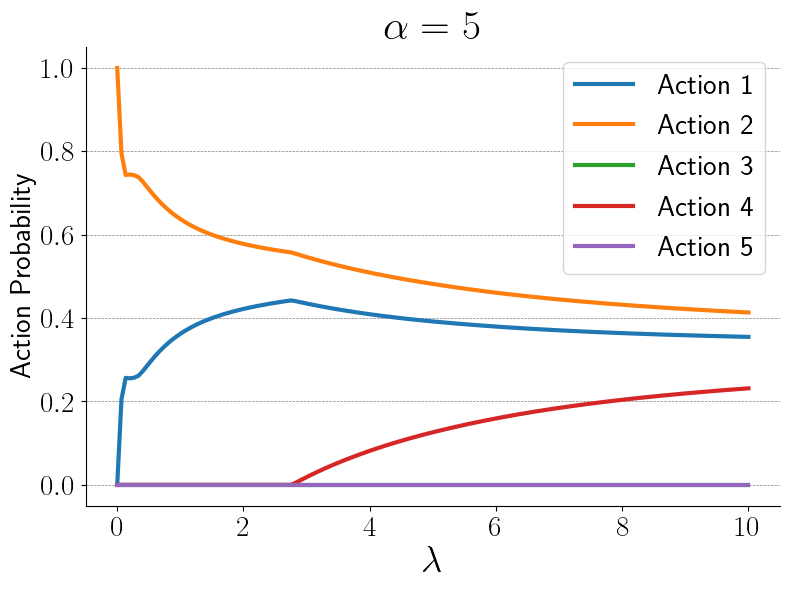

In [7]:
sparsity_values = {alpha: [] for alpha in alphas}
sparsity_values['lambdas'] = lambs

for alpha in alphas:
    # Initialize Value Function
    V0 = np.random.uniform(low=0, high=0.1, size=(S, 1))/(1-gamma)
    
    # Get environments transition matrix and reward function
    P, R = setup_random_mdp(S=S, A=A)
    
    res = {'tsallis': {'lambdas': lambs}}
    
    for lamb in lambs:
        print('Now running Tsallis with lambda: ' + str(lamb))
        v, Pi = Tsallis(S, A, T0, P, R, V0, gamma, lamb, alpha)
    
        # Save Policy 
        for j in range(A):
            if lamb == lambs[0]:
                res['tsallis'][j] = [Pi[0, j]]
            else:
                res['tsallis'][j].append(Pi[0, j])
            
        # Save sparsity values
        count = 0
        for i in range(S):
            count += np.sum(Pi[i, :]>0) # Available actions
        sparsity_values[alpha].append(1 - (count - S)/(S*A - S))

    plot_lambda_data(f'$\\alpha = {alpha}$', res['tsallis'], key='lambdas', fontsize_multiplier=1.5)

/var/folders/rc/9n3vn3bn6nn7dl_qpr6080qh0000gn/T/ipykernel_54531/4191202101.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('coolwarm', len(sorted_alphas))


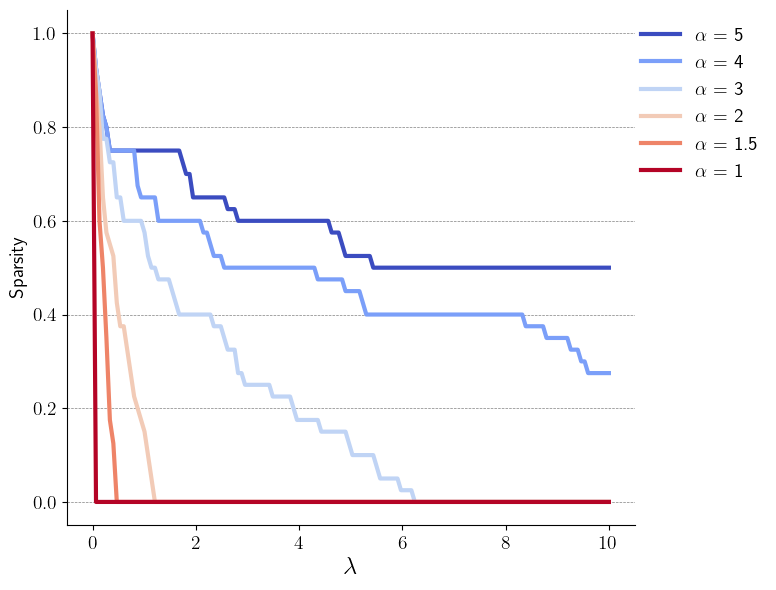

In [8]:
plot_sparsity('', sparsity_values, fontsize_multiplier=1)

# Fixed $\lambda$

In [9]:
lamb = 1
gamma = 0.90
alphas = list(np.linspace(1, 10, 150))

In [10]:
sparsity_values = {lamb: []}
sparsity_values['alphas'] = alphas

res = {'tsallis': {'alphas': alphas}}
for alpha in alphas:
    # Initialize Value Function
    V0 = np.random.uniform(low=0, high=0.1, size=(S, 1))/(1-gamma)
    
    # Get environments transition matrix and reward function
    P, R = setup_random_mdp(S=S, A=A)

    print('Now running Tsallis with alpha: ' + str(alpha))
    v, Pi = Tsallis(S, A, T0, P, R, V0, gamma, lamb, alpha)

    # Save Policy 
    for j in range(A):
        if alpha == alphas[0]:
            res['tsallis'][j] = [Pi[0, j]]
        else:
            res['tsallis'][j].append(Pi[0, j])
        
    # Save sparsity values
    count = 0
    for i in range(S):
        count += np.sum(Pi[i, :]>0) # Available actions
    sparsity_values[lamb].append(1 - (count - S)/(S*A - S))
    print()

Now running Tsallis with alpha: 1.0


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 1085.80it/s]



Now running Tsallis with alpha: 1.0604026845637584


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 209.51it/s]



Now running Tsallis with alpha: 1.1208053691275168


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 250.61it/s]



Now running Tsallis with alpha: 1.1812080536912752


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 252.03it/s]



Now running Tsallis with alpha: 1.2416107382550337


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 130.18it/s]



Now running Tsallis with alpha: 1.302013422818792


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 214.32it/s]



Now running Tsallis with alpha: 1.3624161073825505


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 251.50it/s]



Now running Tsallis with alpha: 1.4228187919463087


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 185.93it/s]



Now running Tsallis with alpha: 1.483221476510067


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 204.58it/s]



Now running Tsallis with alpha: 1.5436241610738255


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 207.08it/s]



Now running Tsallis with alpha: 1.604026845637584


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 205.63it/s]



Now running Tsallis with alpha: 1.6644295302013423


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 198.71it/s]



Now running Tsallis with alpha: 1.7248322147651007


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 205.17it/s]



Now running Tsallis with alpha: 1.7852348993288591


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 266.21it/s]



Now running Tsallis with alpha: 1.8456375838926173


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 248.93it/s]



Now running Tsallis with alpha: 1.9060402684563758


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 250.24it/s]



Now running Tsallis with alpha: 1.9664429530201342


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 247.96it/s]



Now running Tsallis with alpha: 2.0268456375838926


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 200.21it/s]



Now running Tsallis with alpha: 2.087248322147651


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 208.79it/s]



Now running Tsallis with alpha: 2.1476510067114094


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 209.14it/s]



Now running Tsallis with alpha: 2.208053691275168


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 249.93it/s]



Now running Tsallis with alpha: 2.2684563758389262


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 247.70it/s]



Now running Tsallis with alpha: 2.3288590604026846


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 263.79it/s]



Now running Tsallis with alpha: 2.389261744966443


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 245.23it/s]



Now running Tsallis with alpha: 2.4496644295302015


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 203.77it/s]



Now running Tsallis with alpha: 2.51006711409396


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 263.69it/s]



Now running Tsallis with alpha: 2.5704697986577183


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 187.80it/s]



Now running Tsallis with alpha: 2.6308724832214763


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 200.27it/s]



Now running Tsallis with alpha: 2.6912751677852347


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 208.23it/s]



Now running Tsallis with alpha: 2.751677852348993


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 197.61it/s]



Now running Tsallis with alpha: 2.8120805369127515


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 220.03it/s]



Now running Tsallis with alpha: 2.87248322147651


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 260.28it/s]



Now running Tsallis with alpha: 2.9328859060402683


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 196.19it/s]



Now running Tsallis with alpha: 2.9932885906040267


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 231.63it/s]



Now running Tsallis with alpha: 3.053691275167785


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 202.14it/s]



Now running Tsallis with alpha: 3.1140939597315436


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 231.53it/s]



Now running Tsallis with alpha: 3.174496644295302


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 234.36it/s]



Now running Tsallis with alpha: 3.2348993288590604


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 182.84it/s]



Now running Tsallis with alpha: 3.295302013422819


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 197.54it/s]



Now running Tsallis with alpha: 3.3557046979865772


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 215.35it/s]



Now running Tsallis with alpha: 3.4161073825503356


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 229.02it/s]



Now running Tsallis with alpha: 3.476510067114094


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 281.60it/s]



Now running Tsallis with alpha: 3.5369127516778525


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 224.74it/s]



Now running Tsallis with alpha: 3.597315436241611


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 199.82it/s]



Now running Tsallis with alpha: 3.6577181208053693


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 202.56it/s]



Now running Tsallis with alpha: 3.7181208053691277


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 212.25it/s]



Now running Tsallis with alpha: 3.778523489932886


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 208.83it/s]



Now running Tsallis with alpha: 3.8389261744966445


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 240.14it/s]



Now running Tsallis with alpha: 3.899328859060403


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 214.37it/s]



Now running Tsallis with alpha: 3.9597315436241614


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 252.91it/s]



Now running Tsallis with alpha: 4.02013422818792


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 284.28it/s]



Now running Tsallis with alpha: 4.080536912751678


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 253.79it/s]



Now running Tsallis with alpha: 4.140939597315437


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 262.19it/s]



Now running Tsallis with alpha: 4.201342281879195


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 275.40it/s]



Now running Tsallis with alpha: 4.2617449664429525


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 203.12it/s]



Now running Tsallis with alpha: 4.322147651006711


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 212.82it/s]



Now running Tsallis with alpha: 4.382550335570469


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 203.62it/s]



Now running Tsallis with alpha: 4.442953020134228


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 237.97it/s]



Now running Tsallis with alpha: 4.503355704697986


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 221.84it/s]



Now running Tsallis with alpha: 4.563758389261745


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 281.64it/s]



Now running Tsallis with alpha: 4.624161073825503


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 268.49it/s]



Now running Tsallis with alpha: 4.684563758389261


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 225.35it/s]



Now running Tsallis with alpha: 4.74496644295302


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 246.47it/s]



Now running Tsallis with alpha: 4.805369127516778


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 278.18it/s]



Now running Tsallis with alpha: 4.865771812080537


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 286.37it/s]



Now running Tsallis with alpha: 4.926174496644295


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 278.20it/s]



Now running Tsallis with alpha: 4.9865771812080535


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 282.03it/s]



Now running Tsallis with alpha: 5.046979865771812


100%|███████████████████████████████████████████| 49/49 [00:00<00:00, 98.82it/s]



Now running Tsallis with alpha: 5.10738255033557


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 200.85it/s]



Now running Tsallis with alpha: 5.167785234899329


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 195.10it/s]



Now running Tsallis with alpha: 5.228187919463087


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 225.12it/s]



Now running Tsallis with alpha: 5.2885906040268456


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 268.54it/s]



Now running Tsallis with alpha: 5.348993288590604


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 243.19it/s]



Now running Tsallis with alpha: 5.409395973154362


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 221.99it/s]



Now running Tsallis with alpha: 5.469798657718121


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 245.36it/s]



Now running Tsallis with alpha: 5.530201342281879


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 184.05it/s]



Now running Tsallis with alpha: 5.590604026845638


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 191.33it/s]



Now running Tsallis with alpha: 5.651006711409396


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 193.76it/s]



Now running Tsallis with alpha: 5.7114093959731544


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 214.43it/s]



Now running Tsallis with alpha: 5.771812080536913


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 151.18it/s]



Now running Tsallis with alpha: 5.832214765100671


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 270.30it/s]



Now running Tsallis with alpha: 5.89261744966443


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 273.18it/s]



Now running Tsallis with alpha: 5.953020134228188


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 269.24it/s]



Now running Tsallis with alpha: 6.0134228187919465


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 258.43it/s]



Now running Tsallis with alpha: 6.073825503355705


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 275.36it/s]



Now running Tsallis with alpha: 6.134228187919463


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 279.80it/s]



Now running Tsallis with alpha: 6.194630872483222


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 269.58it/s]



Now running Tsallis with alpha: 6.25503355704698


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 229.20it/s]



Now running Tsallis with alpha: 6.315436241610739


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 195.93it/s]



Now running Tsallis with alpha: 6.375838926174497


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 172.20it/s]



Now running Tsallis with alpha: 6.436241610738255


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 199.34it/s]



Now running Tsallis with alpha: 6.496644295302014


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 239.49it/s]



Now running Tsallis with alpha: 6.557046979865772


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 226.78it/s]



Now running Tsallis with alpha: 6.617449664429531


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 219.85it/s]



Now running Tsallis with alpha: 6.677852348993289


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 250.48it/s]



Now running Tsallis with alpha: 6.7382550335570475


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 191.07it/s]



Now running Tsallis with alpha: 6.798657718120806


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 222.96it/s]



Now running Tsallis with alpha: 6.859060402684564


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 212.16it/s]



Now running Tsallis with alpha: 6.919463087248323


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 240.50it/s]



Now running Tsallis with alpha: 6.979865771812081


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 271.87it/s]



Now running Tsallis with alpha: 7.0402684563758395


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 249.46it/s]



Now running Tsallis with alpha: 7.100671140939598


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 184.92it/s]



Now running Tsallis with alpha: 7.161073825503356


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 183.91it/s]



Now running Tsallis with alpha: 7.221476510067115


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 199.21it/s]



Now running Tsallis with alpha: 7.281879194630873


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 195.36it/s]



Now running Tsallis with alpha: 7.342281879194632


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 233.08it/s]



Now running Tsallis with alpha: 7.40268456375839


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 251.10it/s]



Now running Tsallis with alpha: 7.4630872483221475


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 170.41it/s]



Now running Tsallis with alpha: 7.523489932885906


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 216.07it/s]



Now running Tsallis with alpha: 7.583892617449664


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 265.72it/s]



Now running Tsallis with alpha: 7.644295302013423


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 259.52it/s]



Now running Tsallis with alpha: 7.704697986577181


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 255.78it/s]



Now running Tsallis with alpha: 7.76510067114094


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 232.33it/s]



Now running Tsallis with alpha: 7.825503355704698


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 191.24it/s]



Now running Tsallis with alpha: 7.885906040268456


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 213.96it/s]



Now running Tsallis with alpha: 7.946308724832215


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 209.38it/s]



Now running Tsallis with alpha: 8.006711409395972


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 183.88it/s]



Now running Tsallis with alpha: 8.06711409395973


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 208.72it/s]



Now running Tsallis with alpha: 8.12751677852349


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 200.98it/s]



Now running Tsallis with alpha: 8.187919463087248


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 221.03it/s]



Now running Tsallis with alpha: 8.248322147651006


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 189.03it/s]



Now running Tsallis with alpha: 8.308724832214764


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 265.29it/s]



Now running Tsallis with alpha: 8.369127516778523


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 216.15it/s]



Now running Tsallis with alpha: 8.429530201342281


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 164.68it/s]



Now running Tsallis with alpha: 8.48993288590604


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 239.63it/s]



Now running Tsallis with alpha: 8.550335570469798


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 200.86it/s]



Now running Tsallis with alpha: 8.610738255033556


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 224.02it/s]



Now running Tsallis with alpha: 8.671140939597315


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 112.89it/s]



Now running Tsallis with alpha: 8.731543624161073


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 256.69it/s]



Now running Tsallis with alpha: 8.791946308724832


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 247.43it/s]



Now running Tsallis with alpha: 8.85234899328859


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 242.64it/s]



Now running Tsallis with alpha: 8.912751677852349


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 210.53it/s]



Now running Tsallis with alpha: 8.973154362416107


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 213.11it/s]



Now running Tsallis with alpha: 9.033557046979865


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 212.66it/s]



Now running Tsallis with alpha: 9.093959731543624


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 228.62it/s]



Now running Tsallis with alpha: 9.154362416107382


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 249.24it/s]



Now running Tsallis with alpha: 9.21476510067114


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 261.08it/s]



Now running Tsallis with alpha: 9.275167785234899


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 222.83it/s]



Now running Tsallis with alpha: 9.335570469798657


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 261.96it/s]



Now running Tsallis with alpha: 9.395973154362416


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 234.02it/s]



Now running Tsallis with alpha: 9.456375838926174


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 253.97it/s]



Now running Tsallis with alpha: 9.516778523489933


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 273.17it/s]



Now running Tsallis with alpha: 9.577181208053691


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 273.66it/s]



Now running Tsallis with alpha: 9.63758389261745


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 256.39it/s]



Now running Tsallis with alpha: 9.697986577181208


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 189.61it/s]



Now running Tsallis with alpha: 9.758389261744966


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 207.84it/s]



Now running Tsallis with alpha: 9.818791946308725


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 253.04it/s]



Now running Tsallis with alpha: 9.879194630872483


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 273.43it/s]



Now running Tsallis with alpha: 9.939597315436242


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 274.38it/s]



Now running Tsallis with alpha: 10.0


100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 254.35it/s]

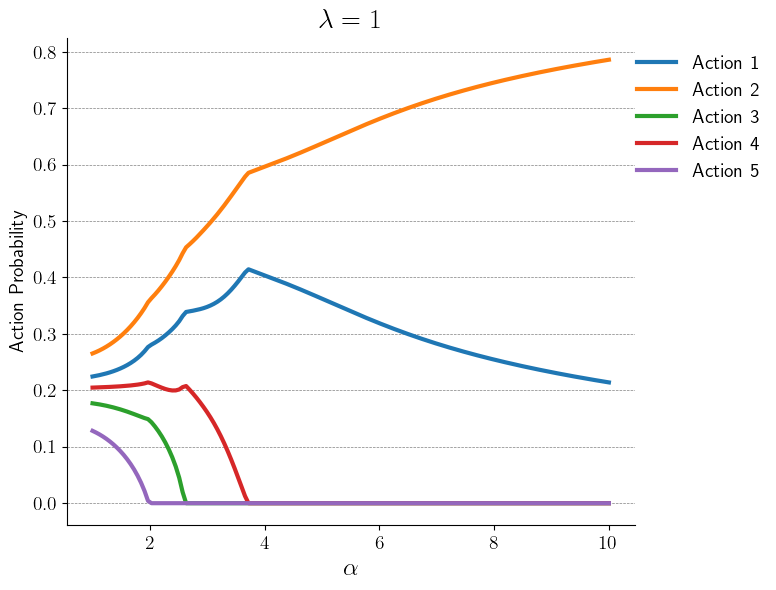

In [14]:
plot_lambda_data(r'$\lambda = 1$', res['tsallis'], key='alphas')